# Quantify Intracellular Object **Distribution** - part 2.3
--------------------
## **OBJECTIVE**
### <input type="checkbox"/> Quantify ***distribution*** of objects within the cell
In this notebook, the logic for quantifying cellular ***distribution*** in XY and Z is outlined.

-----------------
## **Organelle Distribution Measurments**

### summary of steps

#### **PART 1️⃣: XY DISTRIBUTION**

> ###### 📝 **Here we are refering to the XY distribution as the spread of organelles from the nucleus out to the cell membrane. This is similar to the calculations done in [CellProfiler](https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.5/modules/measurement.html?highlight=distribution#module-cellprofiler.modules.measureobjectintensitydistribution)**

- **`1`** - Create sum projections (summed on Z-axis)

    - Make 2D sum projection of binary segmentations (cellmask, nucleus and Golgi body) and visualize

    - define prototype`_create_masked_sum_projection` function

    - compare to finalized `create_masked_sum_projection` function

- **`2`** - Utilize [centrosome](https://github.com/CellProfiler/centrosome) to create concentric rings centered on the nucleus

    - Create a mask representative of pixel distance from the edge of the cell

    - Create a mask representative of how pixels are from the center of our "centering object"

    - Ensure that each cell has a centering object and create a final XY mask

    - Combine the two representations created above to produce one normalized representation of the distance between the centering object and the edge of the cell mask

    - Define prototype `_get_normalized_distance_and_mask` function

    - Compare to finalized `get_normalized_distance_and_mask` function

- **`3`** - Create concentric rings and wedges based on the normalized distance image created above and collect measurements of object distribution within those rings

    - Create a specified number of concentric rings from the normalized distances created above

    - Create radial wedges separating each bin into 8 parts

    - Collect measurements from each bin, including the variance between wedges, and summarize into a table

    - Summarize the distribution data into one comprehensive table

    - Define prototype `_get_concentric_distribution` function

    - Run `_get_concentric_distribution` function (scaled)

    - Compare to finalized `get_concentric_distribution` function

- **`4`** - Collect measurement about the distribution the organelles within each bin using zernike features

    - Specify the number of degress to use for calculating zernike features

    - Define prototype `_zernike_polynomial` function

    - Compare to finalized `zernike_polynomial` function

    - Collect zernike meausurements and define prototype `_zernike_metrics` function

    - Compare to finalized `zernike_metrics` function

    - Create summary table of zernike features

    - Define prototype `_get_zernike_metics` function

    - Compare to finalized `get_zernike_metics` function

- **`5`** - Combine XY_distirbution and zernike measurements into one dataframe

    - Define prototype of comprehensive function `get_XY_distribution`

    - Compare to finalized `get_XY_distribution` function
    
#### **PART 2️⃣: Z DISTRIBUTION**

> ###### **Segment image in 3D; measure area fraction of each organelle per Z slice; these measurements will act as a frequency distribution of that organelle starting from the bottom of the cellmask (not including neurites) to the top of the cellmask; measurements: mean, median, and standard deviation of the frequency distribution**

- **`1`** - Sum all True pixels in each Z slices (olong the X and Y axes)

    - Sum Golgi body segmentation along the X and Y axes

    - Define prototype `_create_masked_depth_projection` function

    - Compare to finalized `create_masked_depth_projection` function

- **`2`** - Summarize the data using the bin format

    - List the bins (z-slices)

    - Construct the dataframe of summarized Z distribution data

    - Define prototype `_get_Z_distribution` function

    - Compare to finalized `get_Z_distribution` function

## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [1]:
from pathlib import Path
import os
import itertools

import napari
from napari.utils.notebook_display import nbscreenshot

from infer_subc.core.file_io import (read_czi_image,
                                        import_inferred_organelle,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats_helpers import *
from infer_subc.organelles import * 

%load_ext autoreload
%autoreload 2

## **LOAD AND READ IN IMAGE FOR PROCESSING**
> ###### 📝 **Specifically, this will include the raw image and the outputs from segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [2]:
# ## Define the path to the directory that contains the input image folder.
# data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

# ## Specify which subfolder that contains the input data and what the file type is. Ex) ".czi" or ".tiff"
# in_data_path = data_root_path / "raw_single"
# raw_img_type = ".czi"

# ## Specify which subfolder contains the segmentation outputs and their file type
# seg_data_path = data_root_path / "out_single"
# seg_img_type = ".tiff"

# ## Specify the name of the output folder where quantification results will be saved
# out_data_path = data_root_path / "quant_single"

# # Specify which file you'd like to segment from the img_file_list
# test_img_n = 0

## Define the path to the directory that contains the input image folder.
data_root_path = Path("E:/Experiments (C2-117 - current)/C2-121")

## Specify which subfolder that contains the input data and what the file type is. Ex) ".czi" or ".tiff"
in_data_path = data_root_path / "C2-121_deconvolution/test"
raw_img_type = ".tiff"

## Specify which subfolder contains the segmentation outputs and their file type
seg_data_path = data_root_path / "20230921_C2-121_3D-analysis/C2-121_good-segs/test"
seg_img_type = ".tiff"

## Specify the name of the output folder where quantification results will be saved
out_data_path = data_root_path / "20230921_C2-121_3D-analysis"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0


#### &#x1F3C3; **Run code; no user input required**

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

raw_file_list = list_image_files(in_data_path, raw_img_type)
seg_file_list = list_image_files(seg_data_path, seg_img_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
raw_img_name = raw_file_list[test_img_n]

raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [5]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("nuc", raw_meta_dict, seg_data_path, seg_img_type)
cell_seg = import_inferred_organelle("cell", raw_meta_dict, seg_data_path, seg_img_type)
# cyto_seg = import_inferred_organelle("cyto", raw_meta_dict, seg_data_path, seg_img_type)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path, seg_img_type)

#organelles
lyso_seg = import_inferred_organelle("lyso", raw_meta_dict, seg_data_path, seg_img_type)
mito_seg = import_inferred_organelle("mito", raw_meta_dict, seg_data_path, seg_img_type)
golgi_seg = import_inferred_organelle("golgi", raw_meta_dict, seg_data_path, seg_img_type)
perox_seg = import_inferred_organelle("perox", raw_meta_dict, seg_data_path, seg_img_type)
ER_seg = import_inferred_organelle("ER", raw_meta_dict, seg_data_path, seg_img_type)
LD_seg = import_inferred_organelle("LD", raw_meta_dict, seg_data_path, seg_img_type)

loaded  inferred 3D `nuc`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `cell`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `lyso`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `mito`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `golgi`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `perox`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `ER`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 
loaded  inferred 3D `LD`  from E:\Experiments (C2-117 - current)\C2-121\20230921_C2-121_3D-analysis\C2-121_good-segs\test 


# ***PART 1️⃣: XY DISTRIBUTION***

## **`1` - Create sum projections**

We will create a sum projection of the cell mask, nucleus, and each object (e.g., organelle) we want to measure the distribution of. Here we are using the golgi segmentation as an example. The cell mask and nucleus will be important for creating the distribution "bins" that will span from the nucleus to the cell periphery.

> ***Sum projection***
>
> A sum projection adds together the voxel intensity at each XY position to produce a single XY plane representative of the entire Z intensity.
> Here, we will be creating sum projections of the binary segmentations, so the "intensity" is representative of the number of voxels at each XY position that are "True", or object.

- Make 2D sum projection of binary segmentations (cellmask, nucleus and Golgi body) and visualize

In [6]:
# cell mask and nucleus projections
test_cell_proj = cell_seg.astype(bool).sum(axis=0)

nuc_masked = apply_mask(nuc_seg.astype(bool), cell_seg.astype(bool))
test_nuc_proj = nuc_masked.sum(axis=0)

# test organelle projection
golgi_masked = apply_mask(lyso_seg.astype(bool), cell_seg.astype(bool))
test_golgi_proj = golgi_masked.sum(axis=0)

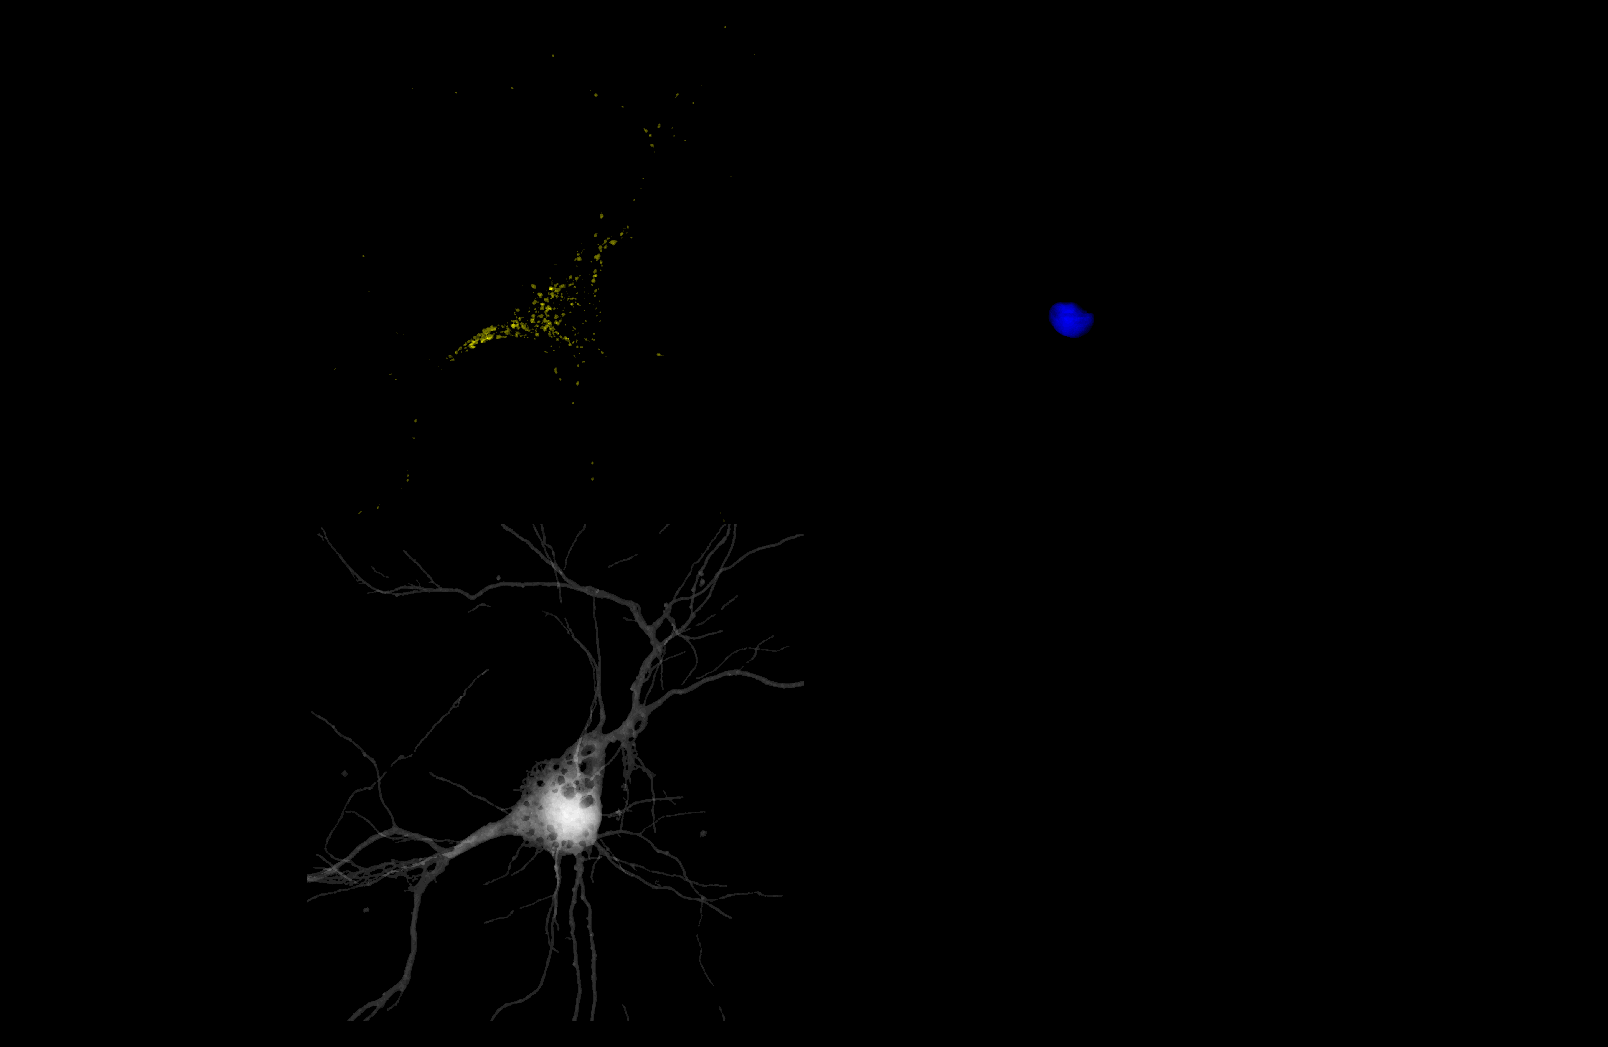

In [7]:
viewer= napari.Viewer()
viewer.add_image(test_cell_proj, colormap="gray")
viewer.add_image(test_nuc_proj, colormap="blue")
viewer.add_image(test_golgi_proj, colormap="yellow")
viewer.grid.enabled = True
nbscreenshot(viewer, canvas_only=True)

In [8]:
viewer.add_image(cell_seg, colormap="gray")
viewer.add_image(nuc_masked, colormap="blue")
viewer.add_image(golgi_masked, colormap="yellow")

<Image layer 'golgi_masked' at 0x191bcd0e410>

- define prototype`_create_masked_sum_projection` function

In [9]:
def _create_masked_sum_projection(img_in:np.ndarray, mask:Union[np.ndarray, None]=None, to_bool:bool=True) -> np.ndarray:
    """
    Parameters:
    ----------
    img_in:
        3D (ZYX) np.ndarray that will be summed along the Z axis
    mask:
        Optional - mask of the region you want to include in the final sum projection
    to_bool:
        True = input image is created in a boolean image before sum projection (useful for segmentation images where each object is coded as a unique ID number; like after skimage.segmentation.label())
        False = original input image is used for the sum projection
    """
    img_out = img_in.astype(bool) if to_bool else img_in
    if mask is not None:
        img_out = apply_mask(img_out, mask)
    
    return img_out.sum(axis=0)

In [10]:
test_cell_proj_a = _create_masked_sum_projection(cell_seg)
test_nuc_proj_a = _create_masked_sum_projection(nuc_seg, cell_seg.astype(bool))
test_golgi_proj_a = _create_masked_sum_projection(lyso_seg, cell_seg.astype(bool))

np.array_equal(test_cell_proj, test_cell_proj_a), np.array_equal(test_nuc_proj, test_nuc_proj_a), np.array_equal(test_golgi_proj, test_golgi_proj_a)

(True, True, True)

- compare to finalized `create_masked_sum_projection` function

In [11]:
from infer_subc.utils.stats import create_masked_sum_projection

test_cell_proj_final = create_masked_sum_projection(cell_seg)

np.array_equal(test_cell_proj, test_cell_proj_final)

True

## **`2` - Utilize [centrosome](https://github.com/CellProfiler/centrosome) to create concentric rings centered on the nucleus**

- Create a mask representative of pixel distance from the edge of the cell

In [12]:
# create binary images of the outer bound (cell) for creating the concentric rings
test_labels = (test_cell_proj_a>0).astype(np.uint16)

# apply a euclidian distance transform for the cellmask projection; brightness represents the distance from the edge of the cell
test_d_to_edge = centrosome.cpmorphology.distance_to_edge(test_labels)

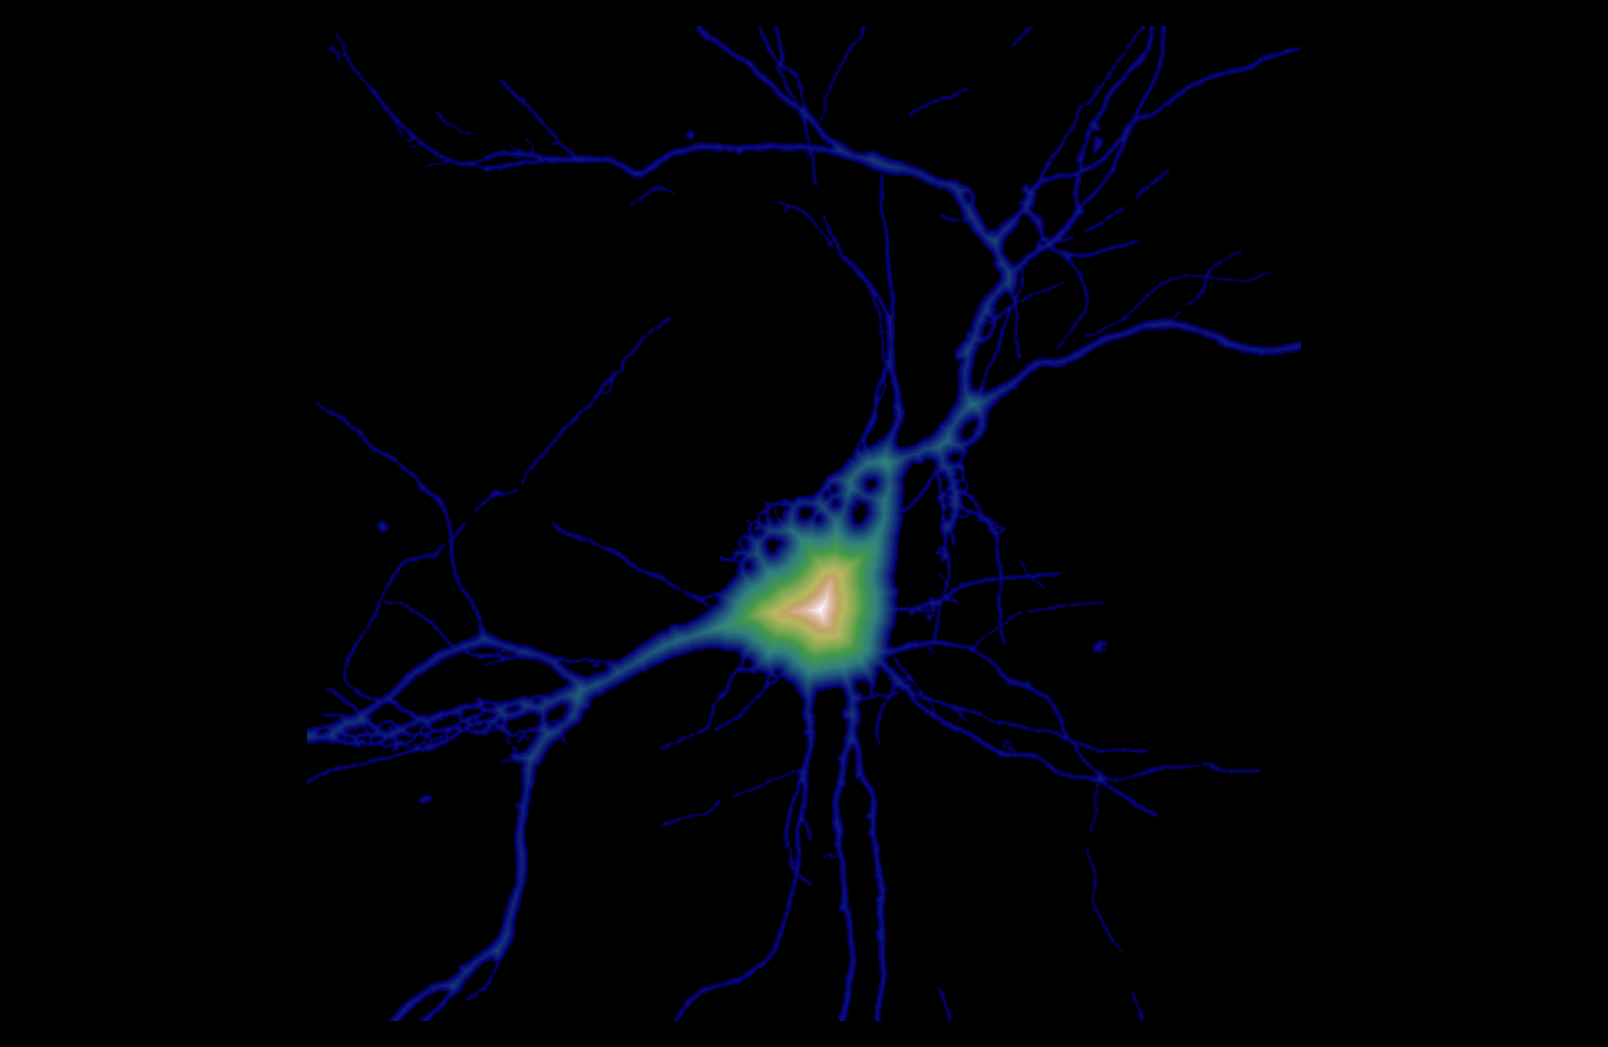

In [13]:
viewer.layers.clear()
viewer.add_image(test_d_to_edge*255, colormap='gist_earth')
nbscreenshot(viewer, canvas_only=True)

- Create a mask representative of how pixels are from the center of our "centering object"

> ###### 📝 **Here we are using the nucleus as the centering object**

In [14]:
# this lists the pixel counts for each cell mask in the image based on the number of unique centering objects
test_center_objects = test_nuc_proj_a>0
test_center_labels = label(test_center_objects)
test_pixel_counts = centrosome.cpmorphology.fixup_scipy_ndimage_result(ndi_sum(np.ones(test_center_labels.shape), 
                                                                               test_center_labels, 
                                                                               np.arange(1, np.max(test_center_labels) + 1, dtype=np.int32)))
test_good = test_pixel_counts > 0

# get the XY coordinates (i,j) of the center of the centering object (nucleus in our case)
test_i, test_j = (centrosome.cpmorphology.centers_of_labels(test_center_labels) + 0.5).astype(int)
test_ig = test_i[test_good]
test_jg = test_j[test_good]

test_lg = np.arange(1, len(test_i) + 1)[test_good]

In [15]:
# Reduce the propagation labels to the center or edge of the centering object

# EXEMPLE 1: propogates distances out from the EDGE of the nucleus; brightest pixels are furthest away from nucleus
test_cl, test_d_from_center = centrosome.propagate.propagate(np.zeros(test_center_labels.shape), test_center_labels, test_labels != 0, 1)
test_cl[test_labels == 0] = 0


# EXAMPLE 2: propogates distances out from the CENTER of the nucleus; brightest pixels are furthest away from nucleus
# True = use center of centering to start bin creation; 
# False = use edge of centering object to propogate bins out
test_center_on_nuc = True 
if test_center_on_nuc:
    test_center_labels_center = np.zeros(test_center_labels.shape, int)
    test_center_labels_center[test_ig, test_jg] = test_lg


test_cl_center, test_d_from_center_center = centrosome.propagate.propagate(np.zeros(test_center_labels_center.shape), test_center_labels_center, test_labels != 0, 1)
test_cl_center[test_labels == 0] = 0

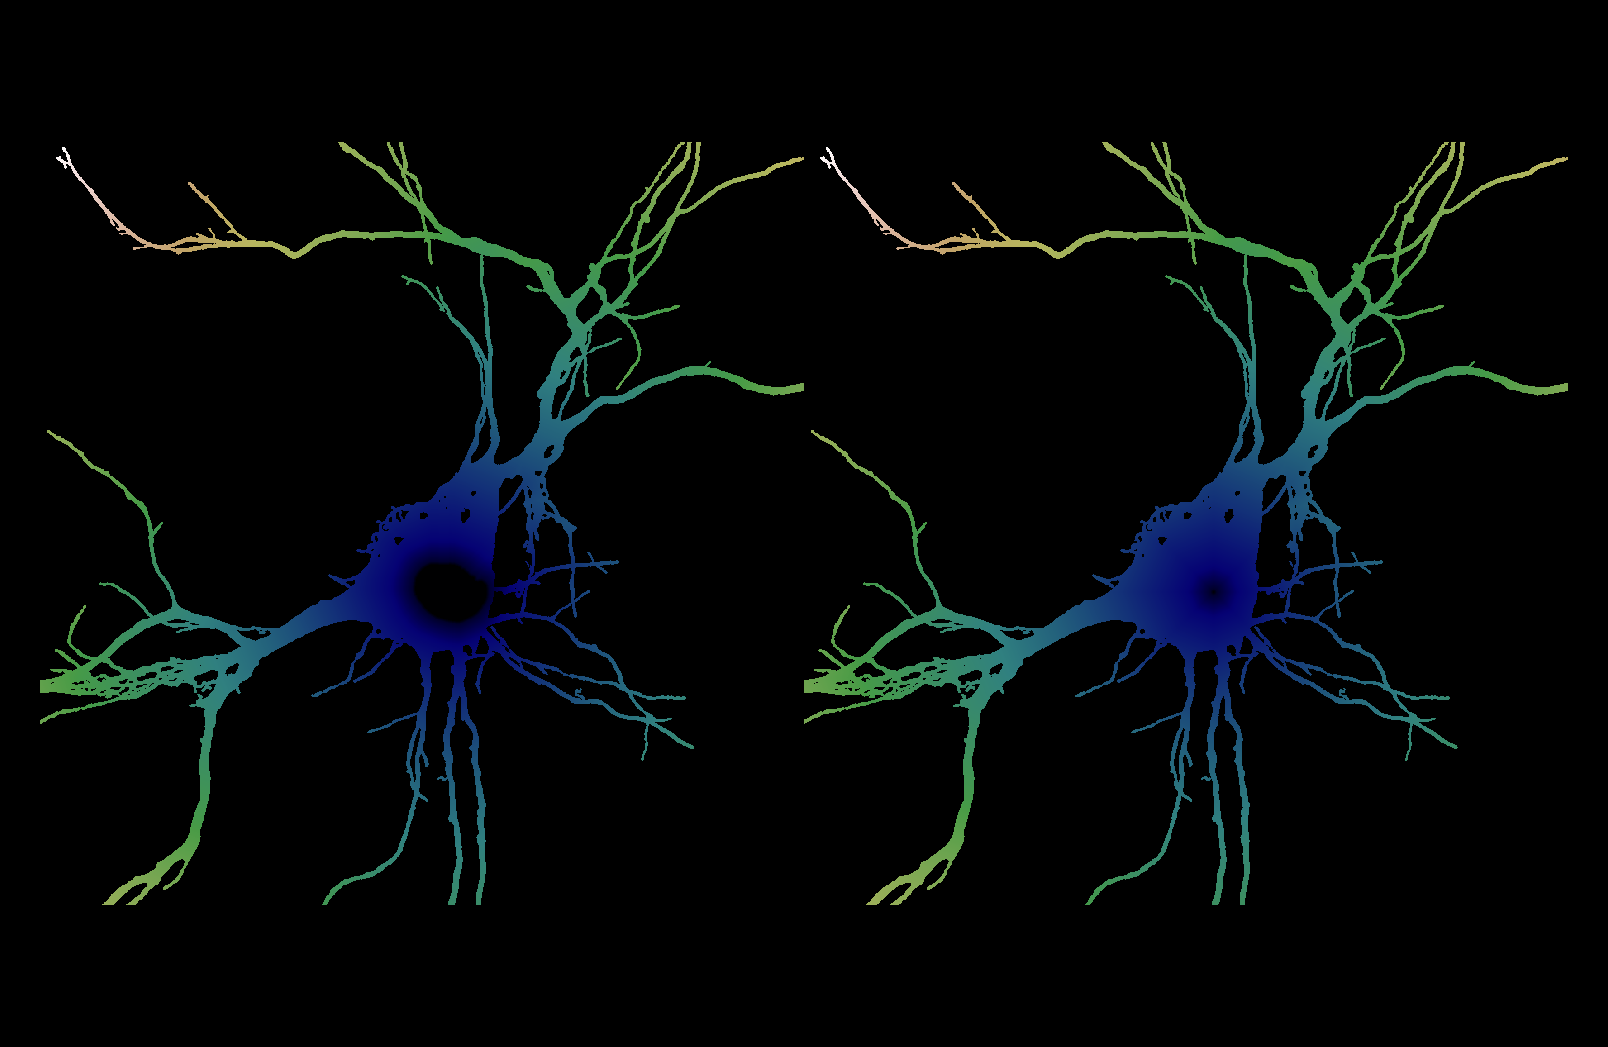

In [16]:
viewer.layers.clear()
viewer.add_image(test_d_from_center_center, colormap='gist_earth')
viewer.add_image(test_d_from_center, colormap='gist_earth')
viewer.grid.enabled = True
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

- Ensure that each cell has a centering object and create a final XY mask

In [17]:
# test for missing centering objects within the cell mask; most important when there are more than one object (cell) in the image
test_missing_mask = (test_labels != 0) & (test_cl == 0)
test_missing_labels = np.unique(test_labels[test_missing_mask])

if len(test_missing_labels):
            print("WTF!!  how did we have missing labels?")
            test_all_centers = centrosome.cpmorphology.centers_of_labels(test_labels)
            test_missing_i_centers, test_missing_j_centers = test_all_centers[:, test_missing_labels-1]
            test_di = test_missing_i_centers[:, np.newaxis] - test_ig[np.newaxis, :]
            test_dj = test_missing_j_centers[:, np.newaxis] - test_jg[np.newaxis, :]
            test_missing_best = test_lg[np.argsort(test_di * test_di + test_dj * test_dj)[:, 0]]
            test_best = np.zeros(np.max(test_labels) + 1, int)
            test_best[test_missing_labels] = test_missing_best
            test_cl[test_missing_mask] = test_best[test_labels[test_missing_mask]]

            # Now compute the crow-flies distance to the centers of these pixels from whatever center was assigned to the object.
            test_iii, test_jjj = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]]
            test_di = test_iii[test_missing_mask] - test_i[test_cl[test_missing_mask] - 1]
            test_dj = test_jjj[test_missing_mask] - test_j[test_cl[test_missing_mask] - 1]
            test_d_from_center[test_missing_mask] = np.sqrt(test_di * test_di + test_dj * test_dj)

# create the projection cell mask that appropriately includes a centering cell mask
test_good_mask = test_cl > 0

WTF!!  how did we have missing labels?


- Combine the two representations created above to produce one normalized representation of the distance between the centering object and the edge of the cell mask

In [18]:
# creating an object equal to the cellmask_proj with all pixel values equal to the X coordinate value (here called 'i') or Y coordinate (here called 'j')
# then creating normalized distance out from center to edge of cell
test_i_center = np.zeros(test_cl.shape)
test_i_center[test_good_mask] = test_i[test_cl[test_good_mask] - 1]

test_j_center = np.zeros(test_cl.shape)
test_j_center[test_good_mask] = test_j[test_cl[test_good_mask] - 1]

test_normalized_distance = np.zeros(test_labels.shape) # creat an empty array
test_total_distance = test_d_from_center + test_d_to_edge # add the two distance arrays together
test_normalized_distance[test_good_mask] = test_d_from_center[test_good_mask] / (test_total_distance[test_good_mask] + 0.001)


# EXAMPLE 2A: INCLUDES the centering object after distances are propogate out from the CENTER of the centering object
test_i_center_center = np.zeros(test_cl_center.shape)
test_i_center_center[test_good_mask] = test_i[test_cl_center[test_good_mask] - 1]

test_j_center_center = np.zeros(test_cl_center.shape)
test_j_center_center[test_good_mask] = test_j[test_cl_center[test_good_mask] - 1]

test_normalized_distance_center = np.zeros(test_labels.shape)
test_total_distance_center = test_d_from_center_center + test_d_to_edge 
test_normalized_distance_center[test_good_mask] = test_d_from_center_center[test_good_mask] / ( test_total_distance_center[test_good_mask] + 0.001)

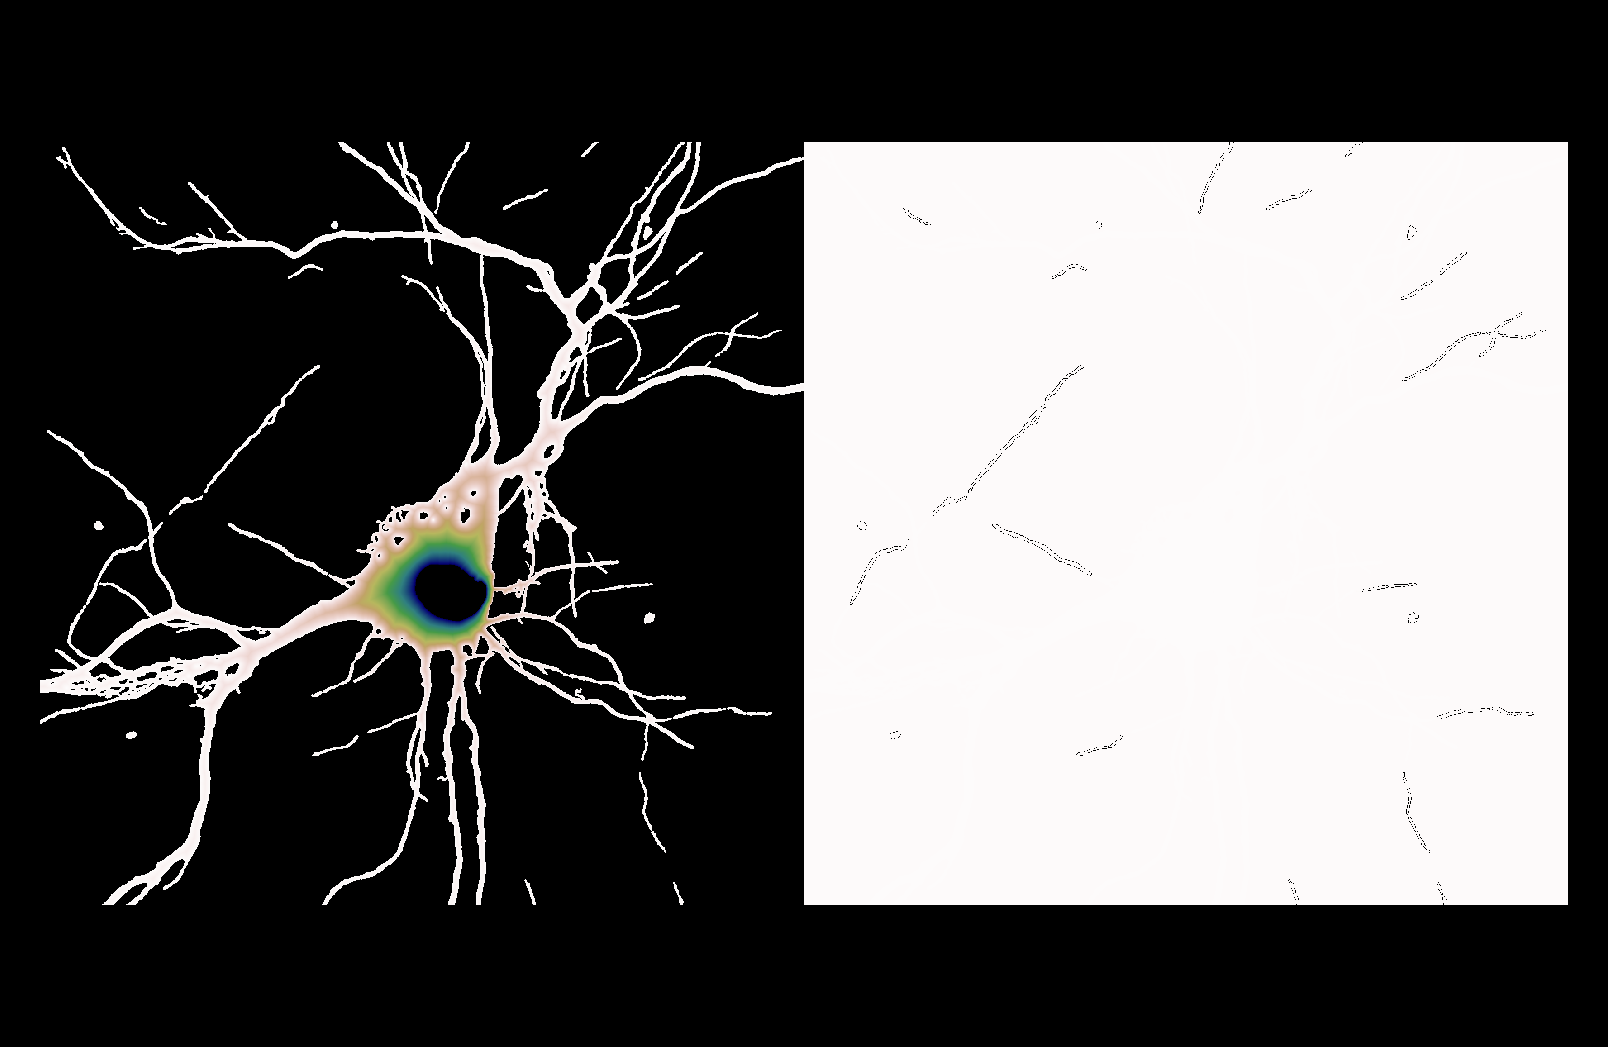

In [19]:
viewer.layers.clear()
viewer.add_image(test_normalized_distance_center, colormap='gist_earth')
viewer.add_image(test_normalized_distance, colormap='gist_earth')
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

In [20]:
viewer.add_image(test_cell_proj>0, colormap="gray")

<Image layer 'Image' at 0x191bce78160>

- Define prototype `_get_normalized_distance_and_mask` function

###### Combine all of the above code into a function to define the normalized distances from the centering object to the edge of the cell mask and create a final projection cell mask to use downstream.

In [21]:
def _get_normalized_distance_and_mask(labels: np.ndarray, 
                                      center_objects: Union[np.ndarray, None], 
                                      center_on: bool):
    """
    helper for radial distribution
    Parameters:
    ----------
    labels:
        2D (YX) np.ndarray - normally the result of a binary ZYX segmentation of the cell mask after a sum projection across the Z dimension
    center_object:
        2D (YX) np.ndarray - normally the result of a binary ZYX segmentation of the nucleus after a sum projection across the Z dimension.
        If no centering object is included, the center of the labels will be used.
    center_on:
        True = the center of the centering object will be used as the starting point to calculate the distance from the center
        False = the edge of the centering object will be used as the starting point to calculate the distance from the center
    
    Output:
    ----------
    normalized_distance:
        2D (YX) np.ndarray with intensity values representing the distance btween the edge of the "labels" and the centering object
    good_mask:
        mask of the areas that were included in the normalized_distance output
    i_center
    j_center
    """

    d_to_edge = centrosome.cpmorphology.distance_to_edge(labels)

    if center_objects is not None:
        center_labels = label(center_objects)
        pixel_counts = centrosome.cpmorphology.fixup_scipy_ndimage_result(ndi_sum(np.ones(center_labels.shape), 
                                                                                  center_labels, 
                                                                                  np.arange(1, np.max(center_labels) + 1, dtype=np.int32)))
        good = pixel_counts > 0
        i, j = (centrosome.cpmorphology.centers_of_labels(center_labels) + 0.5).astype(int)
        ig = i[good]
        jg = j[good]
        lg = np.arange(1, len(i) + 1)[good]
        
        if center_on:  # Reduce the propagation labels to the centers of the centering objects
            center_labels = np.zeros(center_labels.shape, int)
            center_labels[ig, jg] = lg

        cl, d_from_center = centrosome.propagate.propagate(np.zeros(center_labels.shape), center_labels, labels != 0, 1)
        cl[labels == 0] = 0

        missing_mask = (labels != 0) & (cl == 0)
        missing_labels = np.unique(labels[missing_mask])
        
        if len(missing_labels):
            print("WTF!!  how did we have missing labels?")
            all_centers = centrosome.cpmorphology.centers_of_labels(labels)
            missing_i_centers, missing_j_centers = all_centers[:, missing_labels-1]
            di = missing_i_centers[:, np.newaxis] - ig[np.newaxis, :]
            dj = missing_j_centers[:, np.newaxis] - jg[np.newaxis, :]
            missing_best = lg[np.argsort(di * di + dj * dj)[:, 0]]
            best = np.zeros(np.max(labels) + 1, int)
            best[missing_labels] = missing_best
            cl[missing_mask] = best[labels[missing_mask]]

            iii, jjj = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]
            di = iii[missing_mask] - i[cl[missing_mask] - 1]
            dj = jjj[missing_mask] - j[cl[missing_mask] - 1]
            d_from_center[missing_mask] = np.sqrt(di * di + dj * dj)

        good_mask = cl > 0
            
    else:
        i, j = centrosome.cpmorphology.maximum_position_of_labels(d_to_edge, labels, [1])
        center_labels = np.zeros(labels.shape, int)
        center_labels[i, j] = labels[i, j]
        colors = centrosome.cpmorphology.color_labels(labels)
        ncolors = np.max(colors)
        d_from_center = np.zeros(labels.shape)
        cl = np.zeros(labels.shape, int)

        for color in range(1, ncolors + 1):
            mask = colors == color
            l, d = centrosome.propagate.propagate( np.zeros(center_labels.shape), center_labels, mask, 1)
            d_from_center[mask] = d[mask]
            cl[mask] = l[mask]

        good_mask = cl > 0

    i_center = np.zeros(cl.shape)
    i_center[good_mask] = i[cl[good_mask] - 1]

    j_center = np.zeros(cl.shape)
    j_center[good_mask] = j[cl[good_mask] - 1]

    normalized_distance = np.zeros(labels.shape)
    total_distance = d_from_center + d_to_edge
    normalized_distance[good_mask] = d_from_center[good_mask] / (total_distance[good_mask] + 0.001)
    
    return normalized_distance, good_mask, i_center, j_center

In [22]:
test_normalized_distance_a, test_good_mask_a, test_i_center_a, test_j_center_a = _get_normalized_distance_and_mask(labels=test_labels,
                                                                                                                  center_objects=test_center_objects,
                                                                                                                  center_on=False)

np.array_equal(test_normalized_distance, test_normalized_distance_a), np.array_equal(test_good_mask, test_good_mask_a), np.array_equal(test_i_center, test_i_center_a), np.array_equal(test_j_center, test_j_center_a)

WTF!!  how did we have missing labels?


(True, True, True, True)

- Compare to finalized `get_normalized_distance_and_mask` function

In [23]:
from infer_subc.utils.stats import get_normalized_distance_and_mask

test_normalized_distance_final, test_good_mask_final, test_i_center_final, test_j_center_final = get_normalized_distance_and_mask(labels=test_labels,
                                                                                                                  center_objects=test_center_objects,
                                                                                                                  center_on=False)

np.array_equal(test_normalized_distance, test_normalized_distance_final), np.array_equal(test_good_mask, test_good_mask_final), np.array_equal(test_i_center, test_i_center_final), np.array_equal(test_j_center, test_j_center_final)

WTF!!  how did we have missing labels?


(True, True, True, True)

## **`3` - Create concentric rings and wedges based on the normalized distance image created above and collect measurements of object distribution within those rings**

The concentric rings (based on the normalized_distribution output above) will be our main "bins" to measure from. The wedges will divide each bin equally into 8 parts radiall (think pie slices out from the center of the centering object).

See similar concept in [CellProfiler](https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.5/modules/measurement.html?highlight=distribution#module-cellprofiler.modules.measureobjectintensitydistribution)	
   

> ###### 📝 **The logic was borrowed from CellProfiler, but alorithm somewhate simplified by making assumpitions of doing all estimates over a single cellmask (single cell).   Most of the code should be capable of performing the more complicated multi-object versions as CellProfiler does.  Although this functionality is untested the source code was left in this more complex format in case it might be updated for this functionality in the future**

- Create a specified number of concentric rings from the normalized distances created above

In [24]:
# we want to divide the cell area into 5 bins taking into account our center_on and keep_center_as_bin choices above
test_bin_count = 5

# determine if you want to include the centering object as part of the area to measure distribution from or not
test_keep_center_asbin = True

test_good_mask_noNUC = test_good_mask_a>0
test_good_mask_noNUC[test_center_objects] = 0


# EXAMPLE 1A: centering object INCLUDED and distances from the EDGE
test_bin_indexes = ((test_normalized_distance * (test_bin_count-1))+1).astype(int)
test_bin_indexes[test_center_objects]=0
test_bin_indexes[~test_good_mask]=0

# # EXAMPLE 1B: centering object EXCLUDED and distances from the EDGE
test_bin_indexes_noNUC = (test_normalized_distance * test_bin_count).astype(int)

# # EXAMPLE 2A: centering object INCLUDED and distances from the CENTER
test_bin_indexes_center = (test_normalized_distance_center * test_bin_count).astype(int) 

# # EXAMPLE 2B: centering object EXCLUDED and distances from the CENTER
test_normalized_distance_normed = np.zeros_like(test_normalized_distance_center)
test_normalized_distance_normed[test_good_mask_noNUC] = (test_normalized_distance_center[test_good_mask_noNUC] - test_normalized_distance_center[test_good_mask_noNUC].min())/(test_normalized_distance_center[test_good_mask_noNUC].max() - test_normalized_distance_center[test_good_mask_noNUC].min())

test_bin_indexes_noNUC_center = (test_normalized_distance_normed * test_bin_count).astype(int)

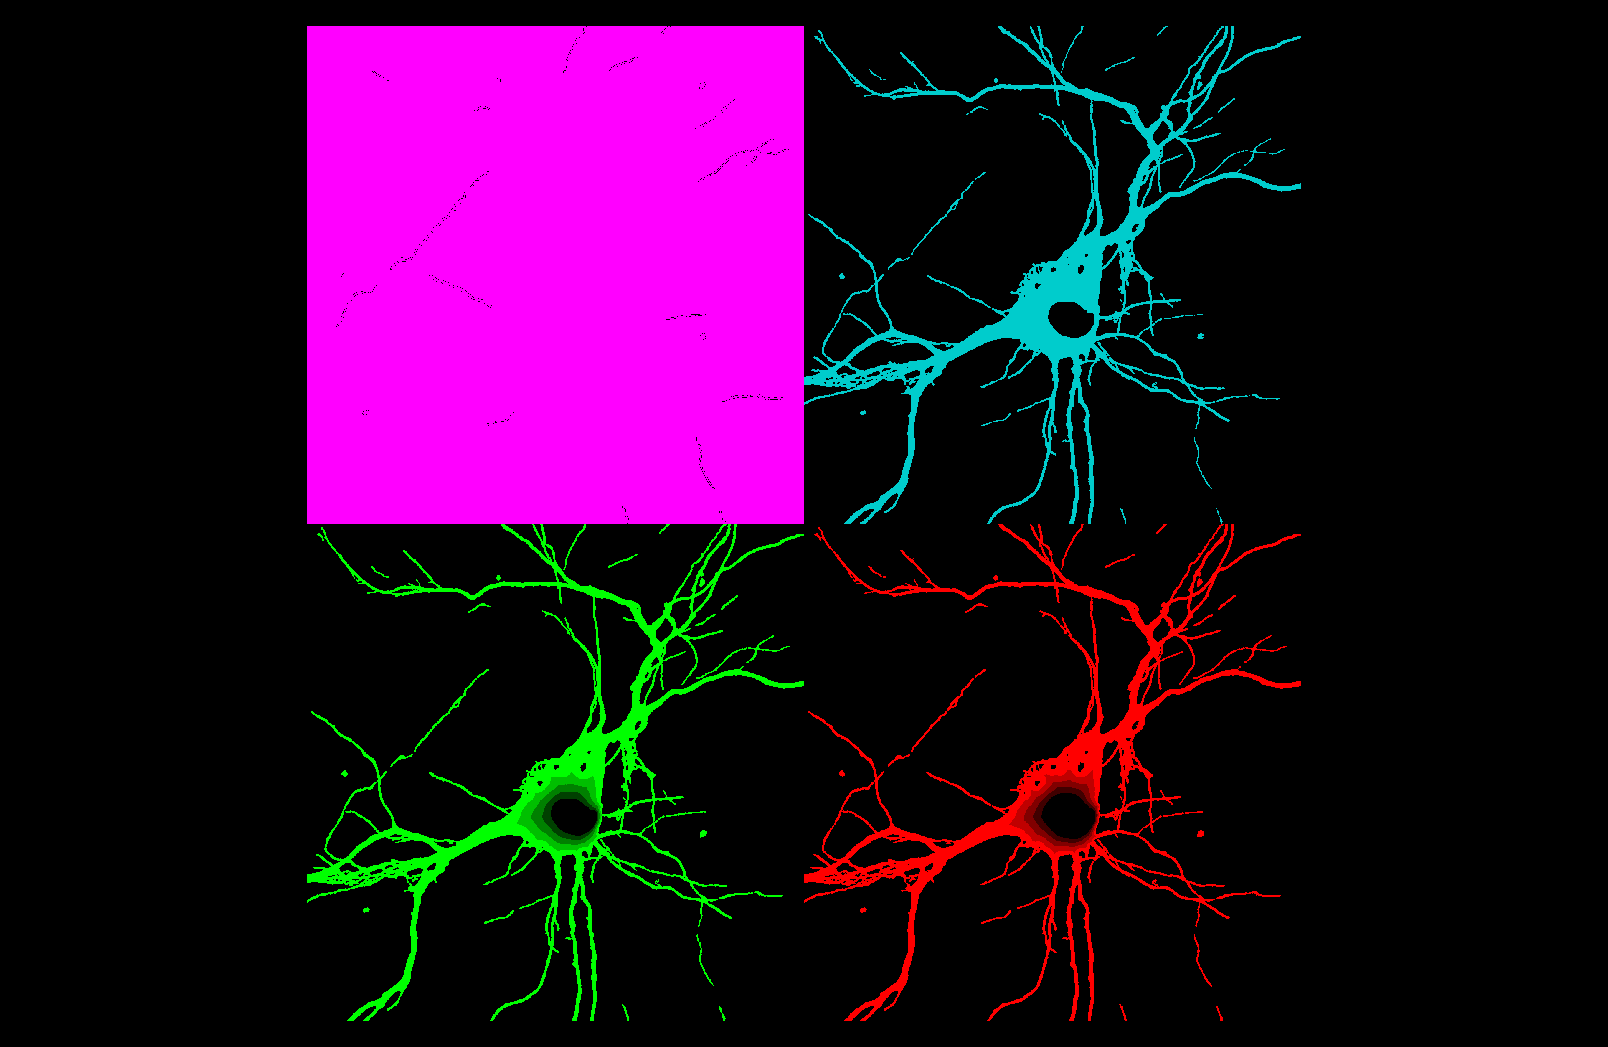

In [25]:
viewer.layers.clear()
viewer.add_image(test_bin_indexes_noNUC, colormap='red')
viewer.add_image(test_bin_indexes, colormap='green')
viewer.add_image(test_bin_indexes_noNUC_center, colormap='cyan') # as an example of what this looks like
viewer.add_image(test_bin_indexes_center, colormap='magenta')
viewer.grid.enabled = True
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

- Create radial wedges separating each bin into 8 parts

In [26]:
# getting radial index for each pixel to create 8 wedges from center of centering object
test_i, test_j = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]] # intensity gradients of pixels in X (top to bottom) and then Y (left to right)
test_imask = test_i[test_good_mask] > test_i_center[test_good_mask]
test_jmask = test_j[test_good_mask] > test_j_center[test_good_mask]
test_absmask = abs(test_i[test_good_mask] - test_i_center[test_good_mask]) > abs(test_j[test_good_mask] - test_j_center[test_good_mask])
test_radial_index = (test_imask.astype(int) + test_jmask.astype(int) * 2 + test_absmask.astype(int) * 4)

test_radial_index_vis = np.zeros_like(test_good_mask, dtype=int)
test_radial_index_vis[test_good_mask] = test_radial_index

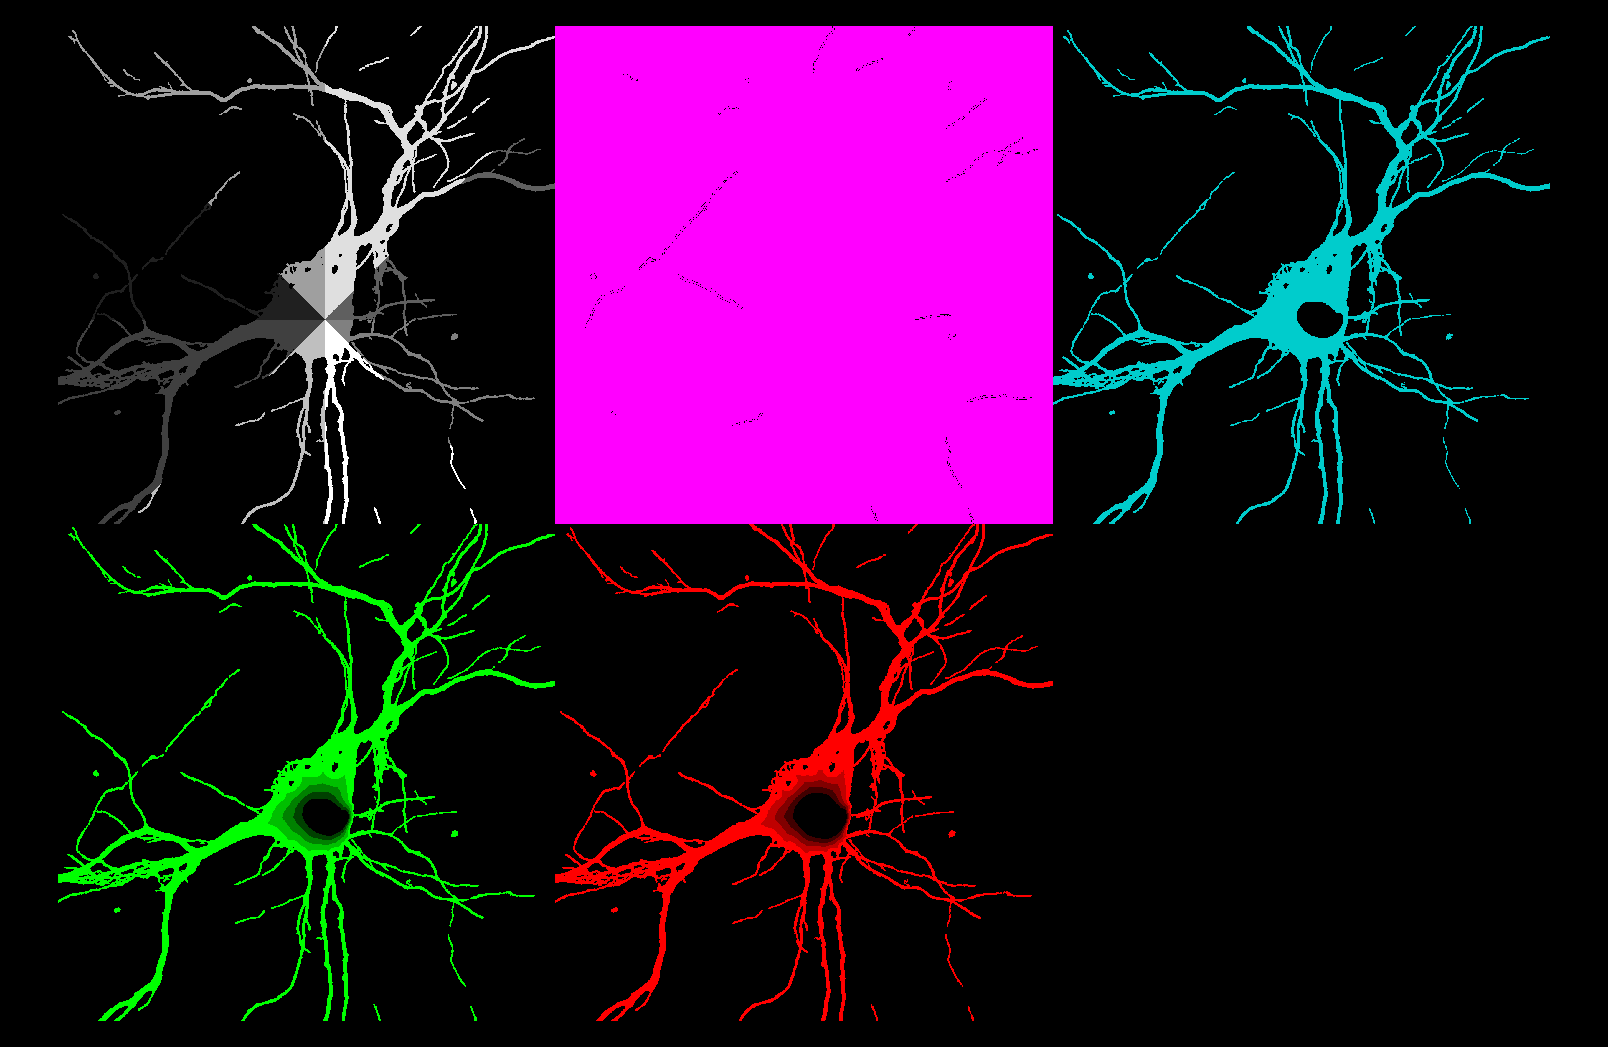

In [27]:
# viewer.layers.clear()
viewer.grid.enabled = True
viewer.add_image(test_good_mask + test_radial_index_vis)
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

In [ ]:
viewer.add_image(test_bin_indexes==1, colormap='green')

<Image layer 'Image [1]' at 0x191ba563b80>

In [31]:
bin1 = test_bin_indexes==1
viewer.add_image(apply_mask(test_good_mask + test_radial_index_vis,bin1))

<Image layer 'Image [2]' at 0x192f4d7e8f0>

- Collect measurements from each bin, including the variance between wedges, and summarize into a table

In [32]:
## These measurements are only using the bins created from the edge of the centerin object and including the centering object area
# number of pixels in the good mask
test_ngood_pixels = np.sum(test_good_mask)

test_good_labels = test_labels[test_good_mask]
test_labels_and_bins = (test_good_labels - 1, test_bin_indexes[test_good_mask])
test_nobjects = 1

# get count of voxels in each bin from the following images
test_histogram_cmsk = coo_matrix((test_cell_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count)).toarray().squeeze().tolist()
test_histogram_org = coo_matrix((test_golgi_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count)).toarray().squeeze().tolist()
test_histogram_center = coo_matrix((test_nuc_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count)).toarray().squeeze().tolist()

# QC: total voxel counts for the entire object
# test_sum_by_object_cmsk = np.sum(test_histogram_cmsk, 1) # cell mask voxel count
# test_sum_by_object_org = np.sum(test_histogram_org, 1)  # organelle voxel count
# test_sum_by_object_nuc = np.sum(test_histogram_center, 1)  # nucleus voxel count

# same concept, but with an empty array to calculate the number of pixels per bin
test_pxl_per_bin = coo_matrix((np.ones(test_ngood_pixels), test_labels_and_bins), (test_nobjects, test_bin_count)).toarray().squeeze().tolist()
test_total_pxls = np.sum(test_pxl_per_bin) # total pixels in the mask; QC: should equal the XY mask area

# get the proportion of pixels in each bin (*100 to get percentage of cell pixels per bin)
test_total_pixels_repeated = np.dstack([test_total_pxls] * (test_bin_count))[0]
test_portion_of_total_mask_pxls = test_pxl_per_bin / test_total_pixels_repeated

In [33]:
# repeating the calculations above using the wedges instead of the bins
test_labels_and_wedges = (test_good_labels - 1, test_radial_index_vis[test_good_mask])

test_wedge_histogram_cmsk = coo_matrix((test_cell_proj_a[test_good_mask], test_labels_and_wedges), shape=(test_nobjects, 8)).toarray().squeeze().tolist()
test_wedge_histogram_org = coo_matrix((test_golgi_proj_a[test_good_mask], test_labels_and_wedges), shape=(test_nobjects, 8)).toarray().squeeze().tolist()
test_wedge_histogram_center = coo_matrix((test_nuc_proj_a[test_good_mask], test_labels_and_wedges), shape=(test_nobjects, 8)).toarray().squeeze().tolist()

test_pxl_per_wedge = coo_matrix((np.ones(test_ngood_pixels), test_labels_and_wedges), (test_nobjects, 8)).toarray().squeeze().tolist()
test_total_pxls_perwedge = np.sum(test_pxl_per_wedge) 

test_total_pixels_repeated_perwedge = np.dstack([test_total_pxls_perwedge] * (8))[0]
test_portion_of_total_mask_pxls_perwedge = test_pxl_per_wedge / test_total_pixels_repeated_perwedge

In [34]:
test_portion_of_total_mask_pxls_perwedge.squeeze().tolist()

[0.08305444569659302,
 0.23931689603751893,
 0.06450841785336202,
 0.060012066158977334,
 0.12811471957563547,
 0.06631834169996244,
 0.28412958599414906,
 0.07454552698380175]

In [35]:
# collecting per bin measurements info
test_bin_names =[]
test_cv_cmsk = []
test_cv_obj = []
test_cv_center = []
test_cmsk_wedge_perbin = []
test_obj_wedge_perbin = []
test_center_wedge_perbin = []
test_pxl_cnt_wedge_perbin = []
test_wedges_perbin = []

for bin in range(test_bin_count):
    test_bin_mask = test_good_mask & (test_bin_indexes == bin) # selecting the bin as a mask
    test_bin_pixels = np.sum(test_bin_mask) # number of pixels in this bin for downstream calculations

    test_bin_labels = test_labels[test_bin_mask] # selecting portion of the cellmask within this bin

    test_bin_radial_index = test_radial_index[test_bin_indexes[test_good_mask] == bin] # selecting the portion of the wedges associated to this bin
    test_labels_and_radii = (test_bin_labels - 1, test_bin_radial_index) # (i,j) for coo_matrix function taking into account the 8 wedges within this bin
    test_pixel_count = coo_matrix((np.ones(test_bin_pixels), test_labels_and_radii), (test_nobjects, 8) ).toarray() # I think this is getting the number of pixels in each wedge

    test_radial_counts_cmsk = coo_matrix((test_cell_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray() # amount of cell mask voxels per wedge in this bin
    test_radial_counts_obj = coo_matrix((test_golgi_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray() # amount of object voxels per wedges in this bin
    test_radial_counts_center = coo_matrix((test_nuc_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray() # amount of centering object voxels per wedges in this bin

    # safe gaurd against one of the wedges having an area of 0
    # np.ma.masked_array - "Masked values of True exclude the corresponding element from any computation."
    test_mask = test_pixel_count == 0

    test_radial_cmsk_norm = np.ma.masked_array(test_radial_counts_cmsk / test_pixel_count, test_mask)
    test_radial_cv_cmsk = np.std(test_radial_cmsk_norm, 1) / np.mean(test_radial_cmsk_norm, 1)
    test_radial_cv_cmsk[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_cmsk.mask = np.sum(~test_mask, 1) == 0

    test_radial_obj_norm = np.ma.masked_array(test_radial_counts_obj / test_pixel_count, test_mask)
    test_radial_cv_obj = np.std(test_radial_obj_norm, 1) / np.mean(test_radial_obj_norm, 1)
    test_radial_cv_obj[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_obj.mask = np.sum(~test_mask, 1) == 0

    test_radial_center_norm = np.ma.masked_array(test_radial_counts_center / test_pixel_count, test_mask)
    test_radial_cv_center = np.std(test_radial_center_norm, 1) / np.mean(test_radial_center_norm, 1)
    test_radial_cv_center[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_center.mask = np.sum(~test_mask, 1) == 0

    test_bin_name = bin + 1 if bin > 0 else 1
    test_wedges_name = np.ma.masked_array([it+1 for it in range(8)])

    test_bin_names.append(test_bin_name)
    test_cv_cmsk.append(float(np.mean(test_radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
    test_cv_obj.append(float(np.mean(test_radial_cv_obj)))
    test_cv_center.append(float(np.mean(test_radial_cv_center)))
    test_cmsk_wedge_perbin.append(test_radial_counts_cmsk.squeeze().tolist())
    test_obj_wedge_perbin.append(test_radial_counts_obj.squeeze().tolist())
    test_center_wedge_perbin.append(test_radial_counts_center.squeeze().tolist())
    test_pxl_cnt_wedge_perbin.append(test_pixel_count.squeeze().tolist())
    test_wedges_perbin.append(test_wedges_name.data.squeeze().tolist())

- Summarize the distribution data into one table

In [36]:
test_org_name = 'golgi'

test_stat_tab=pd.DataFrame({'object': test_org_name,
                            'XY_n_bins': test_bin_count,
                            'XY_bins': [test_bin_names],
                            'XY_mask_vox_cnt_perbin': [test_histogram_cmsk],
                            'XY_obj_vox_cnt_perbin': [test_histogram_org],
                            'XY_center_vox_cnt_perbin': [test_histogram_center],
                            'XY_n_pix_perbin': [test_pxl_per_bin],
                            'XY_portion_pix_perbin': [test_portion_of_total_mask_pxls.squeeze().tolist()],
                            'XY_n_wedges': 8,
                            'XY_wedges': str([it+1 for it in range(8)]),
                            'XY_mask_vox_cnt_perwedge': [test_wedge_histogram_cmsk],
                            'XY_obj_vox_cnt_perwedge': [test_wedge_histogram_org],
                            'XY_center_vox_cnt_perwedge': [test_wedge_histogram_center],
                            'XY_n_pix_perwedge': [test_pxl_per_wedge],
                            'XY_portion_pix_perwedge': [test_portion_of_total_mask_pxls_perwedge.squeeze().tolist()],
                            'XY_wedges_perbin': [test_wedges_perbin],
                            'XY_mask_vox_cnt_wedges_perbin':[test_cmsk_wedge_perbin],
                            'XY_obj_vox_cnt_wedges_perbin':[test_obj_wedge_perbin],
                            'XY_center_vox_cnt_wedges_perbin': [test_center_wedge_perbin],
                            'XY_n_pix_wedges_perbin': [test_pxl_cnt_wedge_perbin],
                            'XY_mask_cv_perbin':[test_cv_cmsk],
                            'XY_obj_cv_perbin':[test_cv_obj],
                            'XY_center_cv_perbin': [test_cv_center]
                            })

# measurements affected by scale
##### volume #####
test_vol_mets = ['XY_mask_vox_cnt_perbin',
            'XY_obj_vox_cnt_perbin',
            'XY_center_vox_cnt_perbin',
            'XY_mask_vox_cnt_perwedge',
            'XY_obj_vox_cnt_perwedge',
            'XY_center_vox_cnt_perwedge',
            'XY_mask_vox_cnt_wedges_perbin',
            'XY_obj_vox_cnt_wedges_perbin',
            'XY_center_vox_cnt_wedges_perbin']

##### area #####
test_area_mets = ['XY_n_pix_perbin',
             'XY_n_pix_perwedge',
             'XY_n_pix_wedges_perbin']

""" 
Measurements
------------
If scale is used, "vox_cnt" is replaced by "vol" and "n_pix_ is replaced by "area" in the title below.

object: the nickname of what is being measured (e.g., golgi, golgiXER, ER_img)
XY_n_bins: number of bins
XY_bins: list of bin number
XY_mask_vox_cnt_perbin: number of voxels in the 3D cell mask per bin
XY_obj_vox_cnt_perbin: number of voxels of the 3D object per bin
XY_center_vox_cnt_perbin: number of voxels of the 3D centering object per bin
XY_n_pix_perbin: number of pixels per bin in the XY mask
XY_portion_pix_perbin: the portion of pixels in the XY mask per bin
XY_n_wedges: number of wedges
XY_wedges: list of wedge numbers
XY_mask_vox_cnt_perwedge: number of voxels in the 3D cell mask per wedge
XY_obj_vox_cnt_perwedge: number of voxels of the 3D object per wedge
XY_center_vox_cnt_perwedge: number of voxels of the 3D centering object per wedge
XY_n_pix_perwedge: number of pixels per wedge in the XY mask
XY_portion_pix_perwedge: the portion of pixels in the XY mask per bin
XY_wedges_perbin: list of wedges that have >0 pixels in the mask for all bins
XY_mask_vox_cnt_wedges_perbin: number of voxels in the 3D cell mask per wedge per bin
XY_obj_vox_cnt_wedges_perbin:number of voxels of the 3D object per wedge per bin
XY_center_vox_cnt_wedges_perbin: number of voxels of the 3D centering object per wedge per bin
XY_n_pix_wedges_perbin: number of pixels per wedge per bin in the XY mask
XY_mask_cv_perbin: the coefficient of variance of the wedges within each bin for the mask
XY_obj_cv_perbin: the coefficient of variance of the wedges within each bin for the object segmentation
XY_center_cv_perbin: the coefficient of variance of the wedges within each bin for the centering object
"""

if scale is not None:
    round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
    test_stat_tab.insert(loc=1, column="scale", value=f"{round_scale}")

    for met in test_vol_mets:
        test_stat_tab[met.replace('_vox_cnt_', "_vol_")] = [(np.float_(test_stat_tab[met][0]) * np.prod(scale)).squeeze().tolist()]
    
    for met in test_area_mets:
        test_stat_tab[met.replace('_n_pix_', "_area_")] = [(np.float_(test_stat_tab[met][0]) * np.prod(scale[1:])).squeeze().tolist()]

else: 
    test_stat_tab.insert(loc=2, column="scale", value=f"{tuple(np.ones(3))}")


In [37]:
pd.set_option('display.max_columns', None)

In [38]:
test_stat_tab

,object,scale,XY_n_bins,XY_bins,XY_mask_vox_cnt_perbin,XY_obj_vox_cnt_perbin,XY_center_vox_cnt_perbin,XY_n_pix_perbin,XY_portion_pix_perbin,XY_n_wedges,XY_wedges,XY_mask_vox_cnt_perwedge,XY_obj_vox_cnt_perwedge,XY_center_vox_cnt_perwedge,XY_n_pix_perwedge,XY_portion_pix_perwedge,XY_wedges_perbin,XY_mask_vox_cnt_wedges_perbin,XY_obj_vox_cnt_wedges_perbin,XY_center_vox_cnt_wedges_perbin,XY_n_pix_wedges_perbin,XY_mask_cv_perbin,XY_obj_cv_perbin,XY_center_cv_perbin,XY_mask_vol_perbin,XY_obj_vol_perbin,XY_center_vol_perbin,XY_mask_vol_perwedge,XY_obj_vol_perwedge,XY_center_vol_perwedge,XY_mask_vol_wedges_perbin,XY_obj_vol_wedges_perbin,XY_center_vol_wedges_perbin,XY_area_perbin,XY_area_perwedge,XY_area_wedges_perbin
0,golgi,"(0.4106, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[336257, 150187, 161981, 188126, 1451980]","[3467, 7565, 9328, 9839, 38295]","[138168, 0, 0, 0, 0]","[14616.0, 8329.0, 11910.0, 17166.0, 299375.0]","[0.04159409896526995, 0.023702603330715204, 0....",8,"[1, 2, 3, 4, 5, 6, 7, 8]","[256205, 538929, 146072, 129336, 303127, 17507...","[10290, 31535, 329, 764, 7311, 2770, 12980, 2515]","[23421, 18295, 15671, 18894, 18923, 16489, 108...","[29185.0, 84095.0, 22668.0, 21088.0, 45019.0, ...","[0.08305444569659302, 0.23931689603751893, 0.0...","[[1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, ...","[[59487, 42008, 42028, 48759, 42736, 34595, 28...","[[1150, 950, 75, 120, 524, 90, 322, 236], [208...","[[23421, 18295, 15671, 18894, 18923, 16489, 10...","[[2461.0, 1760.0, 1905.0, 2297.0, 1753.0, 1458...","[0.04756726853045629, 0.09645471585604397, 0.0...","[0.7827020536106357, 0.9744993035841587, 0.808...","[0.11779266823688922, 0.0, 0.0, 0.0, 0.0]","[882.4462783316249, 394.1388854471185, 425.090...","[9.098520616599039, 19.8529877313446, 24.47966...","[362.5971723548475, 0.0, 0.0, 0.0, 0.0]","[672.3641403448968, 1414.3226470675236, 383.33...","[27.004262228094642, 82.75796009358255, 0.8634...","[61.46422017922299, 48.011951162584204, 41.125...","[[156.1129783442824, 110.24247304934885, 110.2...","[[3.017969053674328, 2.493104870426619, 0.1968...","[[61.46422017922299, 48.011951162584204, 41.12...","[93.418497376344, 53.23499347616101, 76.123036...","[186.53659318066502, 537.4951106228551, 144.88...","[[15.729537632949002, 11.249080143840002, 12.1..."


- Define prototype `_get_concentric_distribution` function

In [40]:
def _get_concentric_distribution(
        mask_proj: np.ndarray,
        centering_proj: np.ndarray,
        obj_proj: np.ndarray,
        obj_name: str,
        bin_count: int,
        center_on: bool = False,
        keep_center_as_bin: bool = True,
        scale: Union[tuple, None]=None):
    """
    Based on CellProfiler's measureobjectintensitydistribution. Measure the distribution of segmented objects within a masked area. 
    In our case, we will usually utilize this function to measure the amount of an organelle within the cell.
    Radial bins are created out from a center point, usually the nucleus edge.

    
    Parameters
    ------------
    mask_proj: np.ndarray
        a sum projection of the region you want to measure the distribution from where the "intensity" value of each pixel is equal 
        to the number of z slices where the binary cell mask is True
    centering_proj: np.ndarray
        a sum projection of the object you want to use as the center of the distribution where the "intensity" value of each pixel is 
        equal to the number of z slices where the binary nucleus mask is True
    obj_proj: np.ndarray,
        a sum projection of the stuff you want to measure where the "intensity" value of each pixel is equal to the number of z slices 
        where the binary organelle mask is True (for a segmented image) or the total intensity at that point (for a gray scale image)
    obj_name: str,
        the name or nickname of your object being measured; used for labeling columns in the dataframe
    bin_count: int,
        the number of concentric rings, or "bins", to create within the mask
    center_on: bool = False,
        True = distribute the bins from the center of the centering object
        False = distribute the bins from the edge of the centering object
    keep_center_as_bin: bool = True
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins
    scale: Union[tuple, None]=None
        a tuple of floats representing the real-world dimensions for each image dimension (ZYX)
        

    Measurements
    ------------
    If scale is used, "vox_cnt" is replaced by "vol" and "n_pix_ is replaced by "area" in the title below.

    object: the nickname of what is being measured (e.g., golgi, golgiXER, ER_img)
    XY_n_bins: number of bins
    XY_bins: list of bin number
    XY_mask_vox_cnt_perbin: number of voxels in the 3D cell mask per bin
    XY_obj_vox_cnt_perbin: number of voxels of the 3D object per bin
    XY_center_vox_cnt_perbin: number of voxels of the 3D centering object per bin
    XY_n_pix_perbin: number of pixels per bin in the XY mask
    XY_portion_pix_perbin: the portion of pixels in the XY mask per bin
    XY_n_wedges: number of wedges
    XY_wedges: list of wedge numbers
    XY_mask_vox_cnt_perwedge: number of voxels in the 3D cell mask per wedge
    XY_obj_vox_cnt_perwedge: number of voxels of the 3D object per wedge
    XY_center_vox_cnt_perwedge: number of voxels of the 3D centering object per wedge
    XY_n_pix_perwedge: number of pixels per wedge in the XY mask
    XY_portion_pix_perwedge: the portion of pixels in the XY mask per bin
    XY_wedges_perbin: list of wedges that have >0 pixels in the mask for all bins
    XY_mask_vox_cnt_wedges_perbin: number of voxels in the 3D cell mask per wedge per bin
    XY_obj_vox_cnt_wedges_perbin:number of voxels of the 3D object per wedge per bin
    XY_center_vox_cnt_wedges_perbin: number of voxels of the 3D centering object per wedge per bin
    XY_n_pix_wedges_perbin: number of pixels per wedge per bin in the XY mask
    XY_mask_cv_perbin: the coefficient of variance of the wedges within each bin for the mask
    XY_obj_cv_perbin: the coefficient of variance of the wedges within each bin for the object segmentation
    XY_center_cv_perbin: the coefficient of variance of the wedges within each bin for the centering object

    
    Returns
    -------------
    tab: (pd.DataFrame) table of measurements of the object distribution
    bin_array: (np.ndarray) mask of the concentric rings to measure distribution from
    wedge_array: (np.ndarray) mask of the wedges (pie slices) that divide each bin into 8 parts
    """
    # other parameters that will stay constant
    nobjects = 1

    # create binary arrays
    center_objects = centering_proj>0 
    mask = (mask_proj>0).astype(np.uint16)


    ################   ################
    ## compute distances and make bins and wedges masks
    ################   ################
    # created normalized distances
    normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(labels=mask, center_objects=center_objects, center_on=center_on)
    if normalized_distance is None:
        print('WTF!!  normalized_distance returned wrong')

    # create bin mask array
    if keep_center_as_bin:
        if center_on:
            bin_array = (normalized_distance * bin_count).astype(int)
        else:
            bin_array= ((normalized_distance * (bin_count-1))+1).astype(int)
            bin_array[center_objects]=0
            bin_array[~good_mask]=0
    else:
        good_mask[center_objects]=0
        if center_on:
            normalized_distance[good_mask] = (normalized_distance[good_mask] - normalized_distance[good_mask].min())/(normalized_distance[good_mask].max() - normalized_distance[good_mask].min())
        bin_array = (normalized_distance * bin_count).astype(int)
            
    bin_array[bin_array > bin_count] = bin_count
    
    # create wedges mask array
    i, j = np.mgrid[0 : mask.shape[0], 0 : mask.shape[1]]
    imask = i[good_mask] > i_center[good_mask]
    jmask = j[good_mask] > j_center[good_mask]
    absmask = abs(i[good_mask] - i_center[good_mask]) > abs(j[good_mask] - j_center[good_mask])
    radial_index = (imask.astype(int) + jmask.astype(int) * 2 + absmask.astype(int) * 4)

    wedge_array = np.zeros_like(good_mask, dtype=int)
    wedge_array[good_mask] = radial_index
    

    ################   ################
    ## get histograms
    ################   ################
    ngood_pixels = np.sum(good_mask)
    good_labels = mask[good_mask]

    # whole cell bin and wedge measurements
    mask_arrays = [bin_array, wedge_array]
    sections = [bin_count, 8]
    types = ['bin', 'wedge']

    met_dict = {}

    for array, num, name in zip(mask_arrays, sections, types):
        labels_and_bins = (good_labels - 1, array[good_mask])

        met_dict[f"XY_mask_vox_cnt_per{name}"] = [coo_matrix((mask_proj[good_mask], labels_and_bins), shape=(nobjects, num)).toarray().squeeze().tolist()]
        met_dict[f"XY_obj_vox_cnt_per{name}"] = [coo_matrix((obj_proj[good_mask], labels_and_bins), shape=(nobjects, num)).toarray().squeeze().tolist()]
        met_dict[f"XY_center_vox_cnt_per{name}"] = [coo_matrix((centering_proj[good_mask], labels_and_bins), shape=(nobjects, num)).toarray().squeeze().tolist()]
        n_pixels = [coo_matrix((np.ones(ngood_pixels), labels_and_bins), (nobjects, num)).toarray().squeeze().tolist()]
        met_dict[f"XY_n_pix_per{name}"] = n_pixels

        total_pixels = np.sum(n_pixels, 1)
        total_repeated = np.dstack([total_pixels] * (num))[0]
        met_dict[f"XY_portion_pix_per{name}"] = [(n_pixels / total_repeated).squeeze().tolist()]


    # per wedge per bin measurements
    bin_names =[]
    cv_mask = []
    cv_obj = []
    cv_center = []
    mask_wedge_perbin = []
    obj_wedge_perbin = []
    center_wedge_perbin = []
    pxl_cnt_wedge_perbin = []
    wedges_perbin = []

    for bin in range(bin_count):
        bin_mask = good_mask & (bin_array == bin)
        bin_pixels = np.sum(bin_mask)

        bin_labels = mask[bin_mask]

        bin_radial_index = radial_index[bin_array[good_mask] == bin]
        labels_and_radii = (bin_labels - 1, bin_radial_index)

        radial_counts_mask = coo_matrix((mask_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_counts_obj = coo_matrix((obj_proj[bin_mask], labels_and_radii), (nobjects, 8)).toarray()
        radial_counts_center = coo_matrix((centering_proj[bin_mask], labels_and_radii), (nobjects, 8)).toarray()
        pixel_count = coo_matrix((np.ones(bin_pixels), labels_and_radii), (nobjects, 8)).toarray()

        n_mask = pixel_count == 0

        radial_counts = [radial_counts_mask, radial_counts_obj, radial_counts_center]
        radial_cvs = []
        for count in radial_counts:
            radial_norm = np.ma.masked_array(count / pixel_count, n_mask)
            radial_cv = np.std(radial_norm, 1) / np.mean(radial_norm, 1)
            radial_cv[np.sum(~n_mask, 1) == 0] = 0
            radial_cv.mask = np.sum(~n_mask, 1) == 0
            radial_cvs.append(radial_cv)

        bin_name = bin + 1 if bin > 0 else 1
        wedges_perbin_name = np.ma.masked_array([it+1 for it in range(8)])

        bin_names.append(bin_name)
        cv_mask.append(float(np.mean(radial_cvs[0])))
        cv_obj.append(float(np.mean(radial_cvs[1])))
        cv_center.append(float(np.mean(radial_cvs[2])))
        mask_wedge_perbin.append(radial_counts[0].squeeze().tolist())
        obj_wedge_perbin.append(radial_counts[1].squeeze().tolist())
        center_wedge_perbin.append(radial_counts[2].squeeze().tolist())
        pxl_cnt_wedge_perbin.append(pixel_count.squeeze().tolist())
        wedges_perbin.append(wedges_perbin_name.data.squeeze().tolist())
    

    ################   ################
    ## create data table and account for scale
    ################   ################
    met_dict_1 = {'object': obj_name,
                    'XY_n_bins': bin_count,
                    'XY_bins': [bin_names]}
    met_dict_2 = dict(list(met_dict.items())[:5])
    met_dict_3 = {'XY_n_wedges': 8,
                    'XY_wedges': str([it+1 for it in range(8)])}
    met_dict_4 = dict(list(met_dict.items())[5:])
    met_dict_5 = {'XY_wedges_perbin': [wedges_perbin],
                    'XY_mask_vox_cnt_wedges_perbin':[mask_wedge_perbin],
                    'XY_obj_vox_cnt_wedges_perbin':[obj_wedge_perbin],
                    'XY_center_vox_cnt_wedges_perbin': [center_wedge_perbin],
                    'XY_n_pix_wedges_perbin': [pxl_cnt_wedge_perbin],
                    'XY_mask_cv_perbin':[cv_mask],
                    'XY_obj_cv_perbin':[cv_obj],
                    'XY_center_cv_perbin': [cv_center]}

    dict_combined = dict(itertools.chain(met_dict_1.items(), met_dict_2.items(), met_dict_3.items(), met_dict_4.items(), met_dict_5.items()))
    tab = pd.DataFrame(dict_combined)

    # account for scale
    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        tab.insert(loc=1, column="scale", value=f"{round_scale}")
        
        # measurements affected by scale
        vol_mets = ['XY_mask_vox_cnt_perbin', 'XY_obj_vox_cnt_perbin', 'XY_center_vox_cnt_perbin', 'XY_mask_vox_cnt_perwedge', 'XY_obj_vox_cnt_perwedge',
                    'XY_center_vox_cnt_perwedge', 'XY_mask_vox_cnt_wedges_perbin', 'XY_obj_vox_cnt_wedges_perbin', 'XY_center_vox_cnt_wedges_perbin']
        area_mets = ['XY_n_pix_perbin', 'XY_n_pix_perwedge', 'XY_n_pix_wedges_perbin']

        for met in vol_mets:
            tab[met.replace('_vox_cnt_', "_vol_")] = [(np.float_(tab[met][0]) * np.prod(scale)).squeeze().tolist()]
        for met in area_mets:
            tab[met.replace('_n_pix_', "_area_")] = [(np.float_(tab[met][0]) * np.prod(scale[1:])).squeeze().tolist()]

    else: 
        tab.insert(loc=2, column="scale", value=f"{tuple(np.ones(3))}")

    return tab, bin_array, wedge_array

In [41]:
pd.set_option('display.max_columns', None)

- Run `_get_concentric_distribution` function (scaled)

In [63]:
test_stats_tab_a, test_bin_indexes_a, test_wedge_indexes_a = _get_concentric_distribution(mask_proj=test_cell_proj_a, 
                                                                                            centering_proj=test_nuc_proj_a, 
                                                                                            obj_proj=test_golgi_proj_a, 
                                                                                            obj_name='lyso', 
                                                                                            scale=scale,
                                                                                            bin_count=5, 
                                                                                            center_on=False,
                                                                                            keep_center_as_bin=True)

results = {}
for col in test_stats_tab_a.columns:
    results[col] = test_stats_tab_a[col][0]==test_stat_tab[col][0]

results, np.array_equal(test_bin_indexes_a,  test_bin_indexes), np.array_equal(test_wedge_indexes_a,  test_radial_index_vis)

WTF!!  how did we have missing labels?


({'object': False,
  'scale': True,
  'XY_n_bins': True,
  'XY_bins': True,
  'XY_mask_vox_cnt_perbin': True,
  'XY_obj_vox_cnt_perbin': True,
  'XY_center_vox_cnt_perbin': True,
  'XY_n_pix_perbin': True,
  'XY_portion_pix_perbin': True,
  'XY_n_wedges': True,
  'XY_wedges': True,
  'XY_mask_vox_cnt_perwedge': True,
  'XY_obj_vox_cnt_perwedge': True,
  'XY_center_vox_cnt_perwedge': True,
  'XY_n_pix_perwedge': True,
  'XY_portion_pix_perwedge': True,
  'XY_wedges_perbin': True,
  'XY_mask_vox_cnt_wedges_perbin': True,
  'XY_obj_vox_cnt_wedges_perbin': True,
  'XY_center_vox_cnt_wedges_perbin': True,
  'XY_n_pix_wedges_perbin': True,
  'XY_mask_cv_perbin': True,
  'XY_obj_cv_perbin': True,
  'XY_center_cv_perbin': True,
  'XY_mask_vol_perbin': True,
  'XY_obj_vol_perbin': True,
  'XY_center_vol_perbin': True,
  'XY_mask_vol_perwedge': True,
  'XY_obj_vol_perwedge': True,
  'XY_center_vol_perwedge': True,
  'XY_mask_vol_wedges_perbin': True,
  'XY_obj_vol_wedges_perbin': True,
  'XY_cen

In [64]:
test_stats_tab_a

,object,scale,XY_n_bins,XY_bins,XY_mask_vox_cnt_perbin,XY_obj_vox_cnt_perbin,XY_center_vox_cnt_perbin,XY_n_pix_perbin,XY_portion_pix_perbin,XY_n_wedges,XY_wedges,XY_mask_vox_cnt_perwedge,XY_obj_vox_cnt_perwedge,XY_center_vox_cnt_perwedge,XY_n_pix_perwedge,XY_portion_pix_perwedge,XY_wedges_perbin,XY_mask_vox_cnt_wedges_perbin,XY_obj_vox_cnt_wedges_perbin,XY_center_vox_cnt_wedges_perbin,XY_n_pix_wedges_perbin,XY_mask_cv_perbin,XY_obj_cv_perbin,XY_center_cv_perbin,XY_mask_vol_perbin,XY_obj_vol_perbin,XY_center_vol_perbin,XY_mask_vol_perwedge,XY_obj_vol_perwedge,XY_center_vol_perwedge,XY_mask_vol_wedges_perbin,XY_obj_vol_wedges_perbin,XY_center_vol_wedges_perbin,XY_area_perbin,XY_area_perwedge,XY_area_wedges_perbin
0,lyso,"(0.4106, 0.0799, 0.0799)",5,"[1, 2, 3, 4, 5]","[336257, 150187, 161981, 188126, 1451980]","[3467, 7565, 9328, 9839, 38295]","[138168, 0, 0, 0, 0]","[14616.0, 8329.0, 11910.0, 17166.0, 299375.0]","[0.04159409896526995, 0.023702603330715204, 0....",8,"[1, 2, 3, 4, 5, 6, 7, 8]","[256205, 538929, 146072, 129336, 303127, 17507...","[10290, 31535, 329, 764, 7311, 2770, 12980, 2515]","[23421, 18295, 15671, 18894, 18923, 16489, 108...","[29185.0, 84095.0, 22668.0, 21088.0, 45019.0, ...","[0.08305444569659302, 0.23931689603751893, 0.0...","[[1, 2, 3, 4, 5, 6, 7, 8], [1, 2, 3, 4, 5, 6, ...","[[59487, 42008, 42028, 48759, 42736, 34595, 28...","[[1150, 950, 75, 120, 524, 90, 322, 236], [208...","[[23421, 18295, 15671, 18894, 18923, 16489, 10...","[[2461.0, 1760.0, 1905.0, 2297.0, 1753.0, 1458...","[0.04756726853045629, 0.09645471585604397, 0.0...","[0.7827020536106357, 0.9744993035841587, 0.808...","[0.11779266823688922, 0.0, 0.0, 0.0, 0.0]","[882.4462783316249, 394.1388854471185, 425.090...","[9.098520616599039, 19.8529877313446, 24.47966...","[362.5971723548475, 0.0, 0.0, 0.0, 0.0]","[672.3641403448968, 1414.3226470675236, 383.33...","[27.004262228094642, 82.75796009358255, 0.8634...","[61.46422017922299, 48.011951162584204, 41.125...","[[156.1129783442824, 110.24247304934885, 110.2...","[[3.017969053674328, 2.493104870426619, 0.1968...","[[61.46422017922299, 48.011951162584204, 41.12...","[93.418497376344, 53.23499347616101, 76.123036...","[186.53659318066502, 537.4951106228551, 144.88...","[[15.729537632949002, 11.249080143840002, 12.1..."


In [67]:
test_stats_tab_a.to_csv("E:/Dissertation/Dissertation figures/Organelle distribution example output/20250214_test-lyso_XY-dist.csv")

In [ ]:
# visualization of organelles within bins and wedges 
fourdim_bins = []
for bin in range(test_bin_count):
    bin_image_2d = test_bin_indexes_a == bin
    bin_image_2d = apply_mask(bin_image_2d, test_good_mask)
    bin_image_4d = np.tile(bin_image_2d, (raw_img_data.shape[0], raw_img_data.shape[1],1,1))
    fourdim_bins.append(bin_image_4d)
fourdim_bins = np.array(fourdim_bins)

viewer.layers.clear()

colors = ["blue","green","yellow","bop orange","gray"]
for bin in range(test_bin_count):
    viewer.add_image(raw_img_data[3] * fourdim_bins[bin][5],
                        colormap=colors[bin],
                        blending="additive",
                        scale=scale,contrast_limits=([0, 10000]),
                        rotate = (5, 5, 0))
viewer.grid.enabled=False
viewer.reset_view()
nbscreenshot(viewer, canvas_only=True)

In [ ]:
viewer.close()

- Compare to finalized `get_concentric_distribution` function

In [ ]:
from infer_subc.utils.stats import get_concentric_distribution

test_stats_tab_final, test_bin_indexes_final, test_wedge_indexes_final = get_concentric_distribution(mask_proj=test_cell_proj_a, 
                                                                                                     centering_proj=test_nuc_proj_a, 
                                                                                                     obj_proj=test_golgi_proj_a, 
                                                                                                     obj_name='golgi', 
                                                                                                     scale=scale,
                                                                                                     bin_count=5, 
                                                                                                     center_on=False,
                                                                                                     keep_center_as_bin=True)

test_stats_tab_a.equals(test_stats_tab_final), np.array_equal(test_bin_indexes_a,  test_bin_indexes_final), np.array_equal(test_wedge_indexes_a,  test_wedge_indexes_final)

## **`4` - Collect measurement about the distribution the organelles within each bin using zernike features**

> ###### The Zernike features characterize the distribution of intensity across the object. For instance, Zernike 1,1 has a high value if the intensity is low on one side of the object and high on the other. The zernike magnitudes feature records the rotationally invariant degree magnitude of the moment and the zernike phase feature gives the moment’s orientation.

> ###### The logic was borrowed from CellProfiler, but alorithm greatly simplified by making assumpitions of doing all estimates over a single cellmask (single cell)

- Specify the number of degress to use for calculating zernike features

In [ ]:
test_labels = label(test_cell_proj_a>0)

# get the zernike indexes based on the number of degrees chosen
test_zernike_degree = 9
test_zernike_indexes = centrosome.zernike.get_zernike_indexes( test_zernike_degree + 1)

In [ ]:
# get the center of the cell mask and the radius of the minimum enclosed circle
test_ij, test_r = centrosome.cpmorphology.minimum_enclosing_circle( test_labels )

# create a gradient of intensities in X and Y
test_iii, test_jjj = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]]

# normalize those values using the center of the cell and radius calculated above
test_iii = (test_iii-test_ij[0][0] ) / test_r
test_jjj = (test_jjj-test_ij[0][1] ) / test_r

# create the zernike polynomials
test_z = centrosome.zernike.construct_zernike_polynomials(test_iii, test_jjj, test_zernike_indexes)

- Define prototype `_zernike_polynomial` function

In [ ]:
def _zernike_polynomial(labels, zernike_is):
    """
    

    """
    # First, get a table of centers and radii of minimum enclosing
    # circles for the cellmask
    ij, r = centrosome.cpmorphology.minimum_enclosing_circle( labels )
    # Then compute x and y, the position of each labeled pixel
    # within a unit circle around the object
    iii, jjj = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]

    # translate+scale
    iii = (iii-ij[0][0] ) / r
    jjj = (jjj-ij[0][1] ) / r

    z = centrosome.zernike.construct_zernike_polynomials(
        iii, jjj, zernike_is
    )
    return z

In [ ]:
test_z_a = _zernike_polynomial(test_labels, test_zernike_indexes)

np.array_equal(test_z, test_z_a)

- Compare to finalized `zernike_polynomial` function

In [ ]:
from infer_subc.utils.stats import zernike_polynomial

test_z_final = zernike_polynomial(test_labels, test_zernike_indexes)

np.array_equal(test_z, test_z_final)

- Collect zernike meausurements and define prototype `_zernike_metrics` function


In [ ]:
# collecting zernike measurements for golgi example
test_vr = np.sum(test_golgi_proj_a[:,:,np.newaxis]*test_z.real, axis=(0,1))
test_vi = np.sum(test_golgi_proj_a[:,:,np.newaxis]*test_z.imag, axis=(0,1))    
test_magnitude = np.sqrt(test_vr * test_vr + test_vi * test_vi) / test_golgi_proj.sum()
test_phase = np.arctan2(test_vr, test_vi)

In [ ]:
def _zernike_metrics(pixels, z):
    """
    
    """
    vr = np.sum(pixels[:,:,np.newaxis]*z.real, axis=(0,1))
    vi = np.sum(pixels[:,:,np.newaxis]*z.imag, axis=(0,1))    
    magnitude = np.sqrt(vr * vr + vi * vi) / pixels.sum()
    phase = np.arctan2(vr, vi)
    return magnitude, phase

In [ ]:
# collecting zernike measurements for cell and nucleus too
test_z_cm = _zernike_metrics(test_cell_proj_a, test_z)
test_z_nuc = _zernike_metrics(test_nuc_proj_a, test_z)
test_z_golgi = _zernike_metrics(test_golgi_proj_a, test_z)

In [ ]:
np.array_equal(test_z_golgi[0], test_magnitude), np.array_equal(test_z_golgi[1], test_phase)

- Compare to finalized `zernike_metrics` function

In [ ]:
from infer_subc.utils.stats import zernike_metrics

test_z_golgi_final = zernike_metrics(test_golgi_proj_a, test_z)

np.array_equal(test_z_golgi, test_z_golgi_final)

- Create summary table of zernike features

In [ ]:
# nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
test_z_stats_tab = pd.DataFrame({'object':'golgi',
                            'zernike_n':[test_zernike_indexes[:,0].tolist()],
                            'zernike_m':[test_zernike_indexes[:,1].tolist()],
                            'zernike_mask_mag':[test_z_cm[0].tolist()],
                            'zernike_mask_phs':[test_z_cm[1].tolist()],   
                            'zernike_obj_mag':[test_z_golgi_final[0].tolist()],
                            'zernike_obj_phs':[test_z_golgi_final[1].tolist()],
                            'zernike_center_mag':[test_z_nuc[0].tolist()],
                            'zernike_center_phs':[test_z_nuc[1].tolist()]})

test_z_stats_tab

- Define prototype `_get_zernike_metrics` function

###### Based on the prototyping above, define the function to quantify and summarize the zernike features

In [ ]:
def _get_zernike_metrics(        
        cellmask_proj: np.ndarray,
        nucleus_proj: Union[np.ndarray, None], 
        org_proj: np.ndarray,
        organelle_name: str,
        zernike_degree: int = 9 ):

    """
    
    """

    labels = label(cellmask_proj>0) #extent as 0,1 rather than bool
    zernike_indexes = centrosome.zernike.get_zernike_indexes( zernike_degree + 1)


    z = zernike_polynomial(labels, zernike_indexes)

    z_cm = zernike_metrics(cellmask_proj, z)
    z_org = zernike_metrics(org_proj, z)
    z_nuc = zernike_metrics(nucleus_proj, z)



    # nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
    stats_tab = pd.DataFrame({'object':organelle_name,
                                'zernike_n':[zernike_indexes[:,0].tolist()],
                                'zernike_m':[zernike_indexes[:,1].tolist()],
                                'zernike_mask_mag':[z_cm[0].tolist()],
                                'zernike_mask_phs':[z_cm[1].tolist()],   
                                'zernike_obj_mag':[z_org[0].tolist()],
                                'zernike_obj_phs':[z_org[1].tolist()],
                                'zernike_center_mag':[z_nuc[0].tolist()],
                                'zernike_center_phs':[z_nuc[1].tolist()]})

    return stats_tab

In [ ]:
test_z_stats_tab_a = _get_zernike_metrics(test_cell_proj_a, test_nuc_proj_a, test_golgi_proj_a, 'golgi', 9)

In [ ]:
test_z_stats_tab.equals(test_z_stats_tab_a)

- Compare to finalized `get_zernike_metics` function

In [ ]:
from infer_subc.utils.stats import get_zernike_metrics

test_z_stats_tab_final = get_zernike_metrics(test_cell_proj_a, test_nuc_proj_a, test_golgi_proj_a, 'golgi', 9)

test_z_stats_tab_final.equals(test_z_stats_tab_a)

In [ ]:
test_combined_tab = pd.merge(test_stats_tab_final, test_z_stats_tab_final, on="object")

test_combined_tab

## **`5` - Combine XY distirbution and zernike measurements into one dataframe**

- Define prototype of comprehensive function `get_XY_distribution`

> ###### 📝 **Based on the prototyping above, define the function to create the sum projections, create the normalized bins from centering object out to the edge of the cell, measure the distribution in the cell, and the zernike distribution within the bins**

In [ ]:
def _get_XY_distribution(        
        mask: np.ndarray,
        centering_obj: np.ndarray,
        obj:np.ndarray,
        obj_name: str,
        scale: Union[tuple, None]=None,
        num_bins: Union[int, None] = 5,
        center_on: bool = False,
        keep_center_as_bin: bool = True,
        zernike_degrees: Union[int, None] = None):

    """
    Params
    ----------
    mask_obj: np.ndarray,
        a binary 3D (ZYX) np.ndarray of the area that will be measured from
    centering_obj: np.ndarray
        a binary 3D (ZYX) np.ndarray of the object that will be used as the center of the concentric rins ("bins")
    obj: np.ndarray
        a 3D (ZYX) np.ndarray image of what will be measured within the masked area
    obj_name: str
        the name or nickname for the obj being measured; this will appear as a column in the output datasheet
    scale: Union[tuple, None]=None
        a tuple that contains the real world dimensions for each dimension in the image (Z, Y, X)
    num_bins: Union[int,None] = None
        the number of concentric rings to draw between the centering object and edge of the mask; None will result in 5 bins
    center_on: bool = False
        True = distribute the bins from the center of the centering object
        False = distribute the bins from the edge of the centering object
    keep_center_as_bin: bool = True
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins
    zernike_degrees: Union[int,None] = None
        the number of zernike degrees to include for the zernike shape descriptors; if None, the zernike measurements will not 
        be included in the output


    Returns
    -----------
    XY_metrics:
        a pandas Dataframe of bin, wedge, and zernike measurements
    dist_bin_mask:
        an np.ndarray mask of the concentric ring bins
    dist_wedge_mask 
        an np.ndarray mask of the 8 radial wedges

    """

    mask_proj = create_masked_sum_projection(mask)
    center_proj = create_masked_sum_projection(centering_obj,mask.astype(bool))
    obj_proj = create_masked_sum_projection(obj,mask.astype(bool))
 

    XY_metrics, dist_bin_mask, dist_wedge_mask = get_concentric_distribution(mask_proj=mask_proj, 
                                                        centering_proj=center_proj, 
                                                        obj_proj=obj_proj, 
                                                        obj_name=obj_name, 
                                                        scale=scale,
                                                        bin_count=num_bins, 
                                                        center_on=center_on,
                                                        keep_center_as_bin=keep_center_as_bin)
    
    if zernike_degrees is not None:
        zernike_metrics = get_zernike_metrics(cellmask_proj=mask_proj, 
                                            org_proj=obj_proj,
                                            organelle_name=obj_name, 
                                            nucleus_proj=center_proj, 
                                            zernike_degree=zernike_degrees)
        
        XY_metrics = pd.merge(XY_metrics, zernike_metrics, on="object")

    return XY_metrics, dist_bin_mask, dist_wedge_mask 

In [ ]:
test_XY_metrics, test_dist_bins, test_dist_wedges = _get_XY_distribution(mask = cell_seg,
                                                                        centering_obj = nuc_seg,
                                                                        obj = golgi_seg,
                                                                        obj_name = 'golgi',
                                                                        scale = scale,
                                                                        num_bins = 5,
                                                                        center_on = False,
                                                                        keep_center_as_bin = True,
                                                                        zernike_degrees = 9)

test_XY_metrics.equals(test_combined_tab), np.array_equal(test_dist_bins, test_bin_indexes_a), np.array_equal(test_dist_wedges, test_radial_index_vis)

- Compare to finalized `get_XY_distribution` function

In [ ]:
from infer_subc.utils.stats import get_XY_distribution

test_XY_metrics_final, test_dist_bins_final, test_dist_wedges_final = get_XY_distribution(mask = cell_seg,
                                                                                          centering_obj = nuc_seg,
                                                                                          obj = golgi_seg,
                                                                                          obj_name = 'golgi',
                                                                                          scale = scale,
                                                                                          num_bins = 5,
                                                                                          center_on = False,
                                                                                          keep_center_as_bin = True,
                                                                                          zernike_degrees = 9)

test_XY_metrics_final.equals(test_combined_tab), np.array_equal(test_dist_bins, test_dist_bins_final), np.array_equal(test_dist_wedges, test_dist_wedges_final)

# ***PART 2️⃣: Z DISTRIBUTION***

## **`1` - Sum all True pixels in each Z slices (olong the X and Y axes)**

- Sum Golgi body segmentation along the X and Y axes

In [52]:
test_golgi_for_Zdist = lyso_seg.astype(bool)

test_golgi_for_Zdist_masked = apply_mask(test_golgi_for_Zdist, cell_seg)

test_golgi_for_Zdist_masked.shape

(34, 1688, 1688)

In [53]:
test_golgi_Zdist = test_golgi_for_Zdist_masked.sum(axis=(1,2))
test_golgi_Zdist.shape, test_golgi_Zdist

((34,),
 array([   0,    0,    0,    7, 1463, 6717, 9754, 8727, 7008, 6577, 6741,
        5961, 4632, 2739, 1632, 1110,  856,  806,  967,  865,  444,  154,
         287,  488,  350,  162,   47,    0,    0,    0,    0,    0,    0,
           0]))

- Define prototype `_create_masked_depth_projection` function

###### Based on the prototyping above, sum the True values along XY for every Z slice

In [54]:
def _create_masked_depth_projection(img_in:np.ndarray, mask:Union[np.ndarray, None]=None, to_bool:bool=True) -> np.ndarray:
    """
    create a masked projection by summing together all XY pixels per Z plane/slice
    """
    img_out = img_in.astype(bool) if to_bool else img_in
    if mask is not None:
        img_out = apply_mask(img_out, mask)
    
    return img_out.sum(axis=(1,2))

In [57]:
golgi_Zdist_final = _create_masked_depth_projection(lyso_seg, cell_seg)
cell_Zdist_final = _create_masked_depth_projection(cell_seg)
nuc_Zdist_final = _create_masked_depth_projection(nuc_seg, cell_seg)

np.array_equal(test_golgi_Zdist, golgi_Zdist_final)

True

In [58]:
print("Cell:")
print(cell_Zdist_final)

print("Nucleus:")
print(nuc_Zdist_final)

print("Lysosomes:")
print(golgi_Zdist_final)

Cell:
[     0      2   2114  64536 170239 213918 233313 227542 194632 164660
 150081 138537 121161 105014  81224  63006  53735  47365  41136  36651
  33445  29754  26124  23046  19047  15684  12623   9071   5814   3090
    620    448    483    416]
Nucleus:
[    0     0     0     0     0     0     0     0    12  1827  6983  9922
 12346 13309 13523 13459 12963 12113 11064  9333  7375  5973  4343  2733
   890     0     0     0     0     0     0     0     0     0]
Lysosomes:
[   0    0    0    7 1463 6717 9754 8727 7008 6577 6741 5961 4632 2739
 1632 1110  856  806  967  865  444  154  287  488  350  162   47    0
    0    0    0    0    0    0]


- Compare to finalized `create_masked_depth_projection` function

In [47]:
from infer_subc.utils.stats import create_masked_depth_projection

golgi_Zdist_final_a = create_masked_depth_projection(golgi_seg, cell_seg)

np.array_equal(golgi_Zdist_final_a, golgi_Zdist_final)

True

## **`2` - Summarize the data using the bin format**

- List the bins (z-slices)

In [48]:
# list the "bins" which in this case as the z-slices
test_z_bins = [i for i in range(cell_seg.shape[0])]
test_z_bins

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33]

- Construct the dataframe of summarized Z distribution data

In [59]:
# summarize the Z distribution data in a table
organelle_name = 'lyso'
test_zdist_stats_tab = pd.DataFrame({'object':organelle_name,
                        'Z_n_slices':cell_seg.shape[0],
                        'Z_slices':[test_z_bins],
                        'Z_mask_vox_cnt':[cell_Zdist_final.tolist()],
                        'Z_obj_vox_cnt':[golgi_Zdist_final.tolist()],
                        'Z_center_vox_cnt':[nuc_Zdist_final.tolist()]})

if scale is not None:
    round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
    test_zdist_stats_tab.insert(loc=1, column="scale", value=f"{round_scale}")

    test_zdist_stats_tab['Z_height'] = cell_seg.shape[0] * scale[0]
    test_zdist_stats_tab['Z_mask_volume'] = [(cell_Zdist_final * np.prod(scale)).tolist()]
    test_zdist_stats_tab['Z_obj_volume'] = [(golgi_Zdist_final * np.prod(scale)).tolist()]
    test_zdist_stats_tab['Z_center_volume'] = [(nuc_Zdist_final * np.prod(scale)).tolist()]
else: 
    test_zdist_stats_tab.insert(loc=2, column="scale", value=f"{tuple(np.ones(3))}")


test_zdist_stats_tab

,object,scale,Z_n_slices,Z_slices,Z_mask_vox_cnt,Z_obj_vox_cnt,Z_center_vox_cnt,Z_height,Z_mask_volume,Z_obj_volume,Z_center_volume
0,lyso,"(0.4106, 0.0799, 0.0799)",34,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 2, 2114, 64536, 170239, 213918, 233313, 22...","[0, 0, 0, 7, 1463, 6717, 9754, 8727, 7008, 657...","[0, 0, 0, 0, 0, 0, 0, 0, 12, 1827, 6983, 9922,...",13.960196,"[0.0, 0.0052486418324770925, 5.547814416928287...","[0.0, 0.0, 0.0, 0.018370246413669824, 3.839381...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031..."


In [61]:
test_zdist_stats_tab.to_csv("E:/Dissertation/Dissertation figures/Organelle distribution example output/20250214_test-lyso_Z-dist.csv")

- Define prototype `_get_Z_distribution` function

###### **Based on the prototyping above, create projections along XY for each Z slice and sum the True pixels**

In [ ]:
def _get_Z_distribution(        
        mask: np.ndarray,
        obj:np.ndarray,
        obj_name: str,
        center_obj: Union[np.ndarray, None],
        scale: Union[tuple, None] = None
        ):
    """
    quantification of distribution along the Z axis; all XY pixels are summed together per Z slice and then quantified

    Parameters
    ------------
    mask_obj: np.ndarray,
        a binary 3D (ZYX) np.ndarray of the area that will be measured from
    obj: np.ndarray
        a 3D (ZYX) np.ndarray image of what will be measured within the masked area
    obj_name: str
        the name or nickname for the obj being measured; this will appear as a column in the output datasheet
    centering_obj: np.ndarray
        optional - a binary 3D (ZYX) np.ndarray utilized as the center/reference point of the area; for cells, this is usually the nucleus
    scale: Union[tuple, None]=None
        a tuple that contains the real world dimensions for each dimension in the image (Z, Y, X)

    Returns
    -----------
    Z_tab:
        a pandas Dataframe of measurements for each z slice

    """

    # flattened
    mask_proj = create_masked_depth_projection(mask)
    obj_proj = create_masked_depth_projection(obj, mask.astype(bool))
    center_proj = create_masked_depth_projection(center_obj, mask.astype(bool)) if center_obj is not None else None

    Zdist_tab = pd.DataFrame({'object':obj_name,
                            'Z_n_slices':mask.shape[0],
                            'Z_slices':[[i for i in range(mask.shape[0])]],
                            'Z_mask_vox_cnt':[mask_proj.tolist()],
                            'Z_obj_vox_cnt':[obj_proj.tolist()],
                            'Z_center_vox_cnt':[center_proj.tolist()]})
    
    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        Zdist_tab.insert(loc=1, column="scale", value=f"{round_scale}")

        Zdist_tab['Z_height'] = mask.shape[0] * scale[0]
        Zdist_tab['Z_mask_volume'] = [(mask_proj * np.prod(scale)).tolist()]
        Zdist_tab['Z_obj_volume'] = [(obj_proj * np.prod(scale)).tolist()]
        Zdist_tab['Z_center_volume'] = [(center_proj * np.prod(scale)).tolist()]
    else: 
        Zdist_tab.insert(loc=2, column="scale", value=f"{tuple(np.ones(3))}")

    return Zdist_tab

In [ ]:
zdist_stats_tab_final = _get_Z_distribution(mask = cell_seg,
                                            obj = golgi_seg,
                                            obj_name = 'golgi',
                                            center_obj = nuc_seg,
                                            scale = scale)

test_zdist_stats_tab.equals(zdist_stats_tab_final)

- Compare to finalized `get_Z_distribution` function

In [ ]:
from infer_subc.utils.stats import get_Z_distribution

zdist_stats_tab_final_a = get_Z_distribution(mask = cell_seg,
                                             obj = golgi_seg,
                                             obj_name = 'golgi',
                                             center_obj = nuc_seg,
                                             scale = scale)

zdist_stats_tab_final_a.equals(zdist_stats_tab_final)